In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

from braindecode.models import EEGNetv4
import copy
import random
import pandas as pd
from tqdm import notebook
import tqdm
from pathlib import Path
import numpy as np
import scipy


torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
c:\Users\machi\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprec

'NVIDIA GeForce GTX 1650'

In [2]:
!nvidia-smi

Mon Oct  6 21:45:58 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.79                 Driver Version: 531.79       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650       WDDM | 00000000:01:00.0 Off |                  N/A |
| N/A   55C    P8                2W /  N/A|      0MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Utilities

In [3]:
from cross_subject_utils import (
    plot_learning_curves,
    evaluate,
    get_windows,
    load_data_from_users,
    get_windows,
)

In [4]:
from cca import CCA_otimizacao, matriz_referencia

In [5]:
def train(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=100,
    device=0,
    save_path="best_model.pth",
):
    best_val_accuracy = -float("inf")
    model.to(device)
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    for epoch in tqdm.notebook.tqdm(range(num_epochs)):
        # Training Phase
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # eval train
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

        train_accuracy = train_correct / train_total
        avg_train_loss = running_loss / len(train_loader)

        # eval validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.inference_mode():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # val accuracy
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_accuracy = val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # Save if best vall acc
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), save_path)
            # print(f"Best model saved with accuracy: {best_val_accuracy:.4f}")

        print(
            f"Epoch {epoch + 1}/{num_epochs}: "
            f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
            f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}"
        )
    plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)
    model.load_state_dict(best_model)
    return model

# Cross Subject

In [6]:
freq_phase_path = (
    "C:/Users/machi/Documents/Mestrado/repos/data/benchmark/Freq_Phase.mat"
)
freq_phase = scipy.io.loadmat(freq_phase_path)
frequencias = np.round(freq_phase["freqs"], 2).ravel()
fases = freq_phase["phases"]

# Parâmetros do pré-processamento
sample_rate = 250
filter_order = 10
freq_cut_high = 70
freq_cut_low = 6
delay = 160

# Parâmetros do CCA
num_harmonica = 5
inform_fase = 0

# Parâmetros de janelas e sessões
tamanho_da_janela_seg = 0.4
tamanho_da_janela = int(np.ceil(tamanho_da_janela_seg * sample_rate))

occipital_electrodes = np.array([47, 53, 54, 55, 56, 57, 60, 61, 62])
frequencias_desejadas = frequencias[:8]
indices = [np.where(frequencias == freq)[0][0] for freq in frequencias_desejadas]

# Usuários
# users = list(range(1, 36))  # Usuários de 1 a 35
users = list(range(1, 11))  # Usuários de 1 a 10

epochs = 1000
exp_dir = Path(
    f"CCA_eegnet/{len(users)}_users_{len(frequencias_desejadas)}_freqs_{tamanho_da_janela_seg}_s/"
)

In [7]:
print("Usuários de interesse:", users)
print(f"Frequencies used: {frequencias_desejadas}")
print(f"Frequencies indices: {indices}")

Usuários de interesse: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Frequencies used: [ 8.  9. 10. 11. 12. 13. 14. 15.]
Frequencies indices: [0, 1, 2, 3, 4, 5, 6, 7]


In [8]:
all_data = load_data_from_users(
    users,
    visual_delay=delay,
    filter_bandpass=True,
    sample_rate=sample_rate,
    freq_cut_low=freq_cut_low,
    freq_cut_high=freq_cut_high,
    filter_order=filter_order,
)

Carregando dados dos usuários:   0%|          | 0/10 [00:00<?, ?it/s]

# Hard code

Processando Usuário 1
Train Users: [2, 3, 4, 5, 6, 7, 8, 9, 10]
0
Generating reference for frequency index 0, frequency 8.0 Hz
theta: 0
y shape: (100, 10)
Y shape: (5400, 10)
Y_train shape after freq 8.0 Hz: (5400, 10, 8)
theta: 0
y shape: (100, 10)
Y shape: (600, 10)
Y_test shape after freq 8.0 Hz: (600, 10, 8)
1
Generating reference for frequency index 1, frequency 9.0 Hz
theta: 0
y shape: (100, 10)
Y shape: (5400, 10)
Y_train shape after freq 9.0 Hz: (5400, 10, 8)
theta: 0
y shape: (100, 10)
Y shape: (600, 10)
Y_test shape after freq 9.0 Hz: (600, 10, 8)
2
Generating reference for frequency index 2, frequency 10.0 Hz
theta: 0
y shape: (100, 10)
Y shape: (5400, 10)
Y_train shape after freq 10.0 Hz: (5400, 10, 8)
theta: 0
y shape: (100, 10)
Y shape: (600, 10)
Y_test shape after freq 10.0 Hz: (600, 10, 8)
3
Generating reference for frequency index 3, frequency 11.0 Hz
theta: 0
y shape: (100, 10)
Y shape: (5400, 10)
Y_train shape after freq 11.0 Hz: (5400, 10, 8)
theta: 0
y shape: (100,

C:\Users\machi\AppData\Local\Temp\ipykernel_13944\2130039968.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_treino = torch.tensor(rotulos_treinamento, dtype=torch.long).to(device)
C:\Users\machi\AppData\Local\Temp\ipykernel_13944\2130039968.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_teste = torch.tensor(rotulos_teste, dtype=torch.long).to(device)


X_train: torch.Size([432, 8, 100])
X_test: torch.Size([48, 8, 100])
Y_train: torch.Size([432])
Y_test: torch.Size([48])


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000: Train Loss: 2.2066, Train Accuracy: 0.0981, Val Loss: 2.0792, Val Accuracy: 0.1692
Epoch 2/1000: Train Loss: 2.1743, Train Accuracy: 0.1580, Val Loss: 2.0791, Val Accuracy: 0.1538
Epoch 3/1000: Train Loss: 2.1957, Train Accuracy: 0.1035, Val Loss: 2.0789, Val Accuracy: 0.1231
Epoch 4/1000: Train Loss: 2.1504, Train Accuracy: 0.1362, Val Loss: 2.0787, Val Accuracy: 0.1077
Epoch 3/1000: Train Loss: 2.1957, Train Accuracy: 0.1035, Val Loss: 2.0789, Val Accuracy: 0.1231
Epoch 4/1000: Train Loss: 2.1504, Train Accuracy: 0.1362, Val Loss: 2.0787, Val Accuracy: 0.1077
Epoch 5/1000: Train Loss: 2.1745, Train Accuracy: 0.1172, Val Loss: 2.0785, Val Accuracy: 0.1077
Epoch 6/1000: Train Loss: 2.1651, Train Accuracy: 0.1281, Val Loss: 2.0784, Val Accuracy: 0.0923
Epoch 5/1000: Train Loss: 2.1745, Train Accuracy: 0.1172, Val Loss: 2.0785, Val Accuracy: 0.1077
Epoch 6/1000: Train Loss: 2.1651, Train Accuracy: 0.1281, Val Loss: 2.0784, Val Accuracy: 0.0923
Epoch 7/1000: Train Loss: 2.16

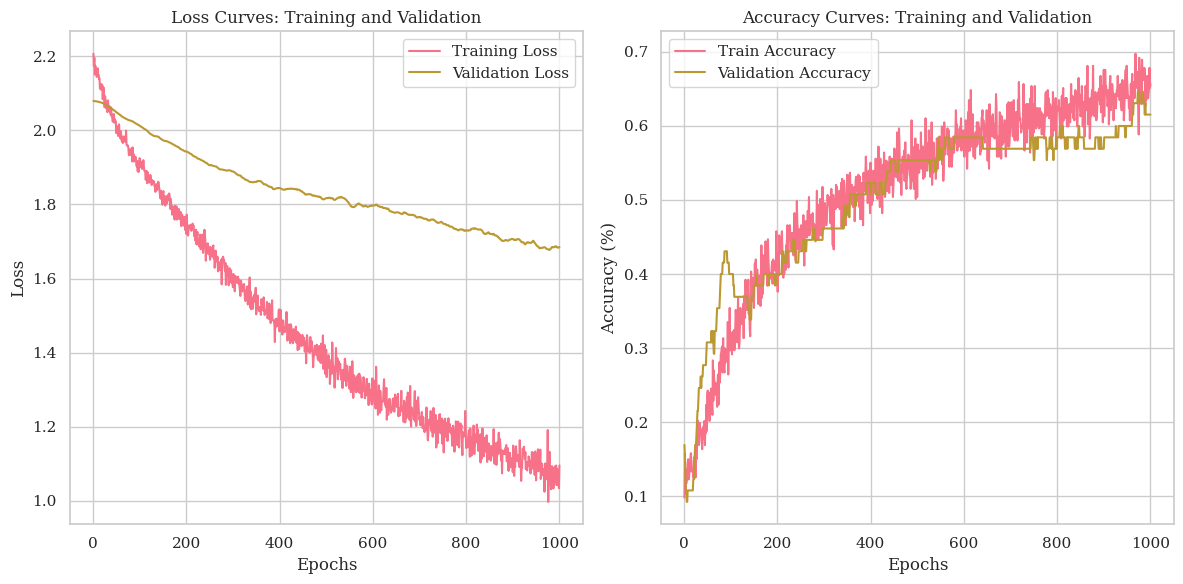

Test set Accuracy: 0.5625
Recall: 0.5625
F1 Score: 0.5589


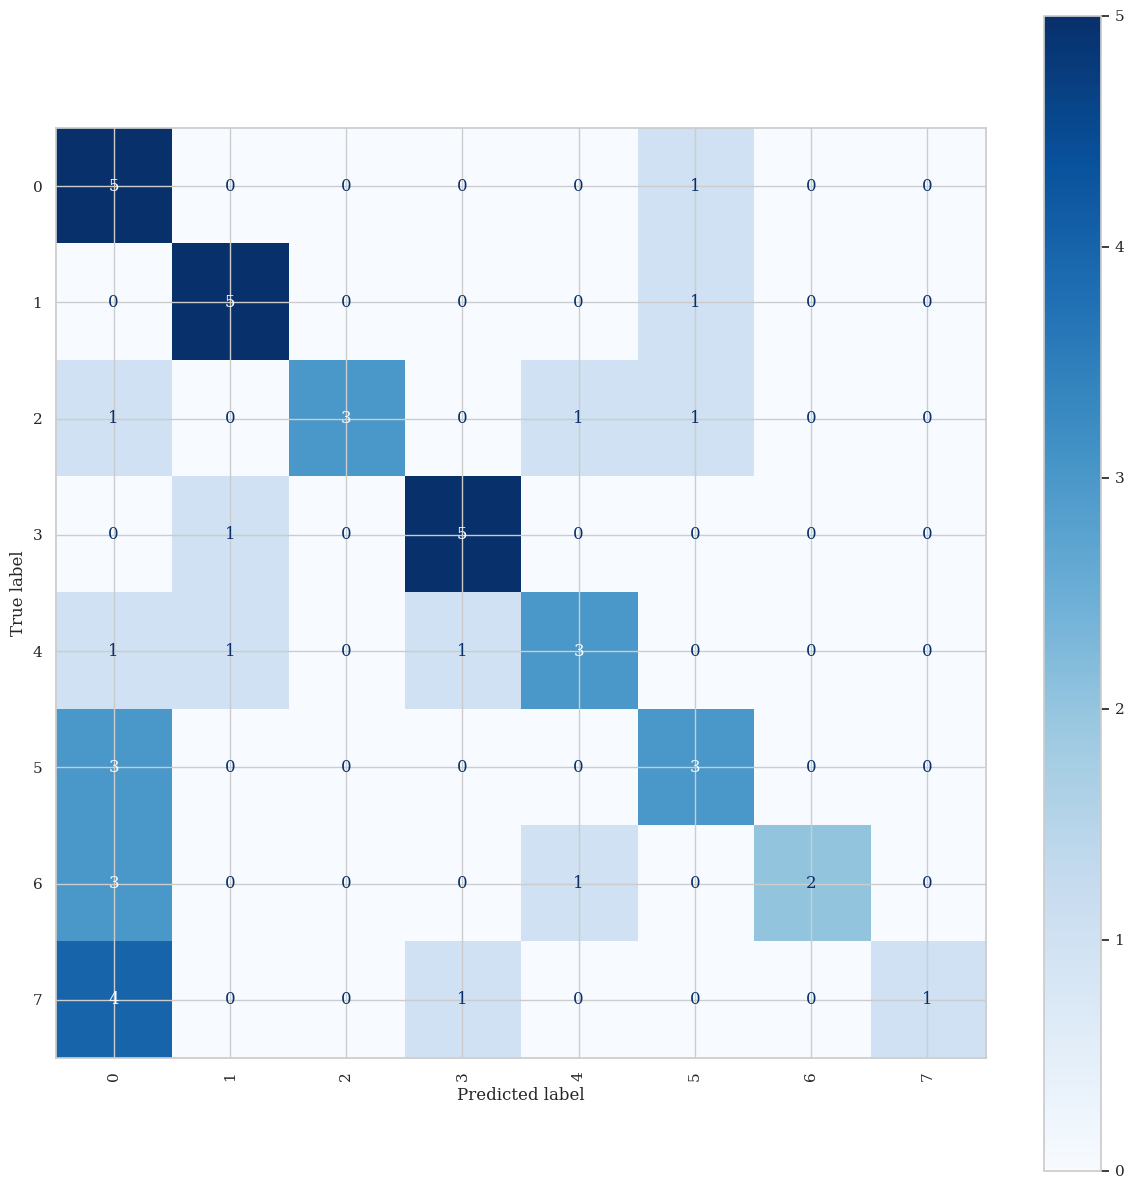

Test User 1 Finished: Accuracy=0.5625, Recall=0.5625, F1=0.5589
--------------------------------------------------
Processando Usuário 2
Train Users: [1, 3, 4, 5, 6, 7, 8, 9, 10]
0
Generating reference for frequency index 0, frequency 8.0 Hz
theta: 0
y shape: (100, 10)
Y shape: (5400, 10)
Y_train shape after freq 8.0 Hz: (5400, 10, 8)
theta: 0
y shape: (100, 10)
Y shape: (600, 10)
Y_test shape after freq 8.0 Hz: (600, 10, 8)
1
Generating reference for frequency index 1, frequency 9.0 Hz
theta: 0
y shape: (100, 10)
Y shape: (5400, 10)
Y_train shape after freq 9.0 Hz: (5400, 10, 8)
theta: 0
y shape: (100, 10)
Y shape: (600, 10)
Y_test shape after freq 9.0 Hz: (600, 10, 8)
2
Generating reference for frequency index 2, frequency 10.0 Hz
theta: 0
y shape: (100, 10)
Y shape: (5400, 10)
Y_train shape after freq 10.0 Hz: (5400, 10, 8)
theta: 0
y shape: (100, 10)
Y shape: (600, 10)
Y_test shape after freq 10.0 Hz: (600, 10, 8)
3
Generating reference for frequency index 3, frequency 11.0 Hz
thet

C:\Users\machi\AppData\Local\Temp\ipykernel_13944\2130039968.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_treino = torch.tensor(rotulos_treinamento, dtype=torch.long).to(device)
C:\Users\machi\AppData\Local\Temp\ipykernel_13944\2130039968.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_teste = torch.tensor(rotulos_teste, dtype=torch.long).to(device)


X_train: torch.Size([432, 8, 100])
X_test: torch.Size([48, 8, 100])
Y_train: torch.Size([432])
Y_test: torch.Size([48])


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000: Train Loss: 2.1659, Train Accuracy: 0.1253, Val Loss: 2.0794, Val Accuracy: 0.1077
Epoch 2/1000: Train Loss: 2.1443, Train Accuracy: 0.1226, Val Loss: 2.0786, Val Accuracy: 0.1231
Epoch 3/1000: Train Loss: 2.1425, Train Accuracy: 0.1281, Val Loss: 2.0778, Val Accuracy: 0.1385
Epoch 4/1000: Train Loss: 2.1351, Train Accuracy: 0.1335, Val Loss: 2.0770, Val Accuracy: 0.1846
Epoch 3/1000: Train Loss: 2.1425, Train Accuracy: 0.1281, Val Loss: 2.0778, Val Accuracy: 0.1385
Epoch 4/1000: Train Loss: 2.1351, Train Accuracy: 0.1335, Val Loss: 2.0770, Val Accuracy: 0.1846
Epoch 5/1000: Train Loss: 2.1286, Train Accuracy: 0.1390, Val Loss: 2.0762, Val Accuracy: 0.1846
Epoch 6/1000: Train Loss: 2.1285, Train Accuracy: 0.1526, Val Loss: 2.0755, Val Accuracy: 0.1846
Epoch 5/1000: Train Loss: 2.1286, Train Accuracy: 0.1390, Val Loss: 2.0762, Val Accuracy: 0.1846
Epoch 6/1000: Train Loss: 2.1285, Train Accuracy: 0.1526, Val Loss: 2.0755, Val Accuracy: 0.1846
Epoch 7/1000: Train Loss: 2.13

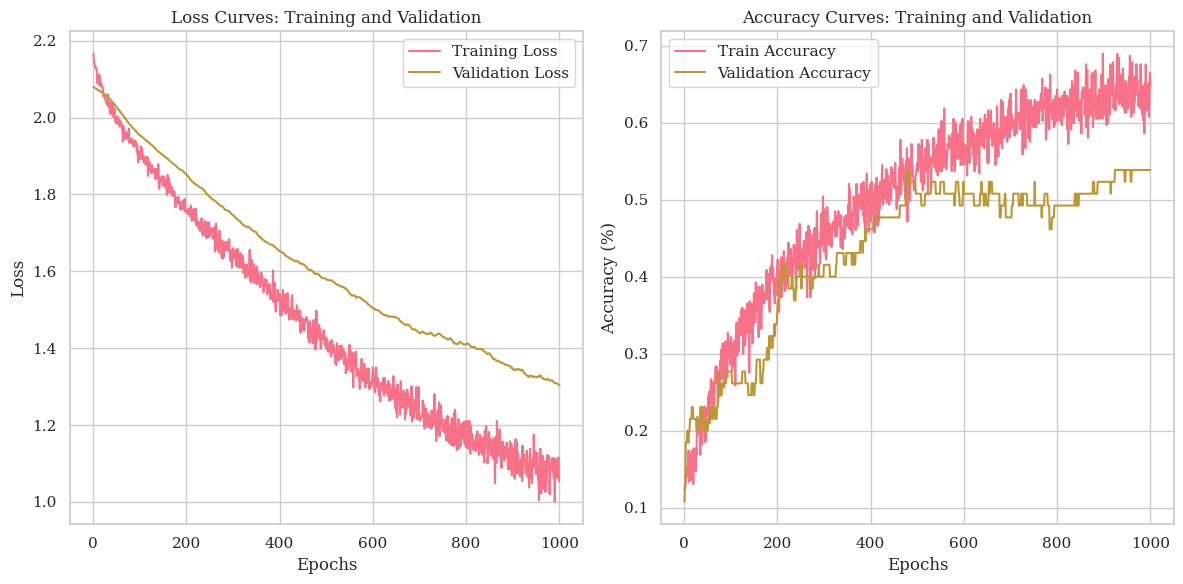

Test set Accuracy: 0.5208
Recall: 0.5208
F1 Score: 0.5326


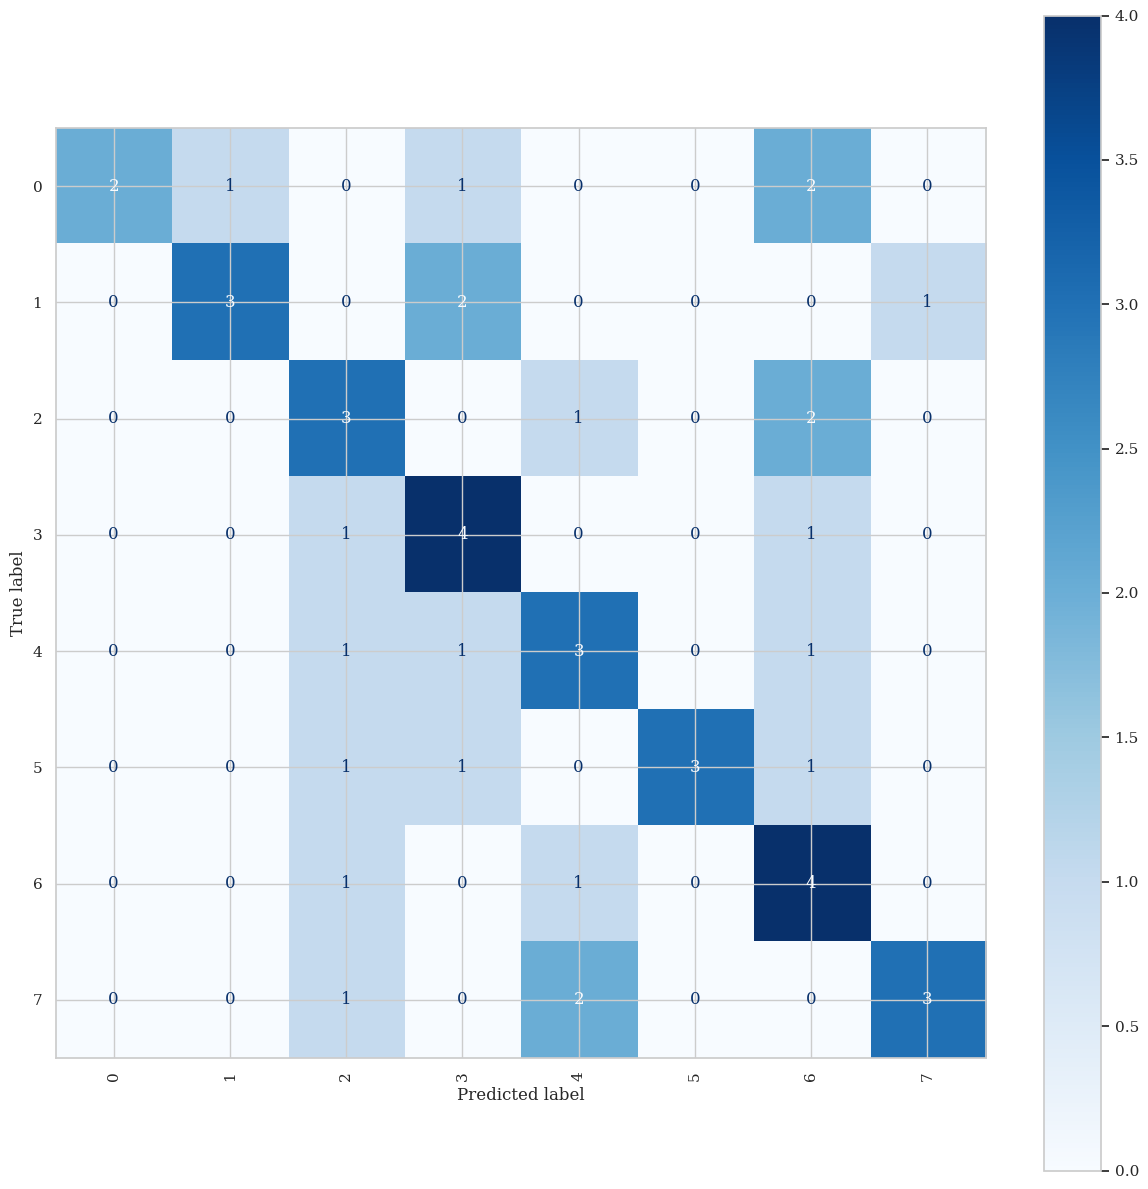

Test User 2 Finished: Accuracy=0.5208, Recall=0.5208, F1=0.5326
--------------------------------------------------
Processando Usuário 3
Train Users: [1, 2, 4, 5, 6, 7, 8, 9, 10]
0
Generating reference for frequency index 0, frequency 8.0 Hz
theta: 0
y shape: (100, 10)
Y shape: (5400, 10)
Y_train shape after freq 8.0 Hz: (5400, 10, 8)
theta: 0
y shape: (100, 10)
Y shape: (600, 10)
Y_test shape after freq 8.0 Hz: (600, 10, 8)
1
Generating reference for frequency index 1, frequency 9.0 Hz
theta: 0
y shape: (100, 10)
Y shape: (5400, 10)
Y_train shape after freq 9.0 Hz: (5400, 10, 8)
theta: 0
y shape: (100, 10)
Y shape: (600, 10)
Y_test shape after freq 9.0 Hz: (600, 10, 8)
2
Generating reference for frequency index 2, frequency 10.0 Hz
theta: 0
y shape: (100, 10)
Y shape: (5400, 10)
Y_train shape after freq 10.0 Hz: (5400, 10, 8)
theta: 0
y shape: (100, 10)
Y shape: (600, 10)
Y_test shape after freq 10.0 Hz: (600, 10, 8)
3
Generating reference for frequency index 3, frequency 11.0 Hz
thet

C:\Users\machi\AppData\Local\Temp\ipykernel_13944\2130039968.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_treino = torch.tensor(rotulos_treinamento, dtype=torch.long).to(device)
C:\Users\machi\AppData\Local\Temp\ipykernel_13944\2130039968.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_teste = torch.tensor(rotulos_teste, dtype=torch.long).to(device)


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000: Train Loss: 2.1309, Train Accuracy: 0.1281, Val Loss: 2.0800, Val Accuracy: 0.0769
Epoch 2/1000: Train Loss: 2.1551, Train Accuracy: 0.0708, Val Loss: 2.0801, Val Accuracy: 0.0615
Epoch 3/1000: Train Loss: 2.1491, Train Accuracy: 0.1226, Val Loss: 2.0802, Val Accuracy: 0.0615
Epoch 4/1000: Train Loss: 2.1070, Train Accuracy: 0.1362, Val Loss: 2.0803, Val Accuracy: 0.0615
Epoch 3/1000: Train Loss: 2.1491, Train Accuracy: 0.1226, Val Loss: 2.0802, Val Accuracy: 0.0615
Epoch 4/1000: Train Loss: 2.1070, Train Accuracy: 0.1362, Val Loss: 2.0803, Val Accuracy: 0.0615
Epoch 5/1000: Train Loss: 2.1367, Train Accuracy: 0.1063, Val Loss: 2.0803, Val Accuracy: 0.0615
Epoch 6/1000: Train Loss: 2.1104, Train Accuracy: 0.1035, Val Loss: 2.0804, Val Accuracy: 0.0615
Epoch 5/1000: Train Loss: 2.1367, Train Accuracy: 0.1063, Val Loss: 2.0803, Val Accuracy: 0.0615
Epoch 6/1000: Train Loss: 2.1104, Train Accuracy: 0.1035, Val Loss: 2.0804, Val Accuracy: 0.0615
Epoch 7/1000: Train Loss: 2.12

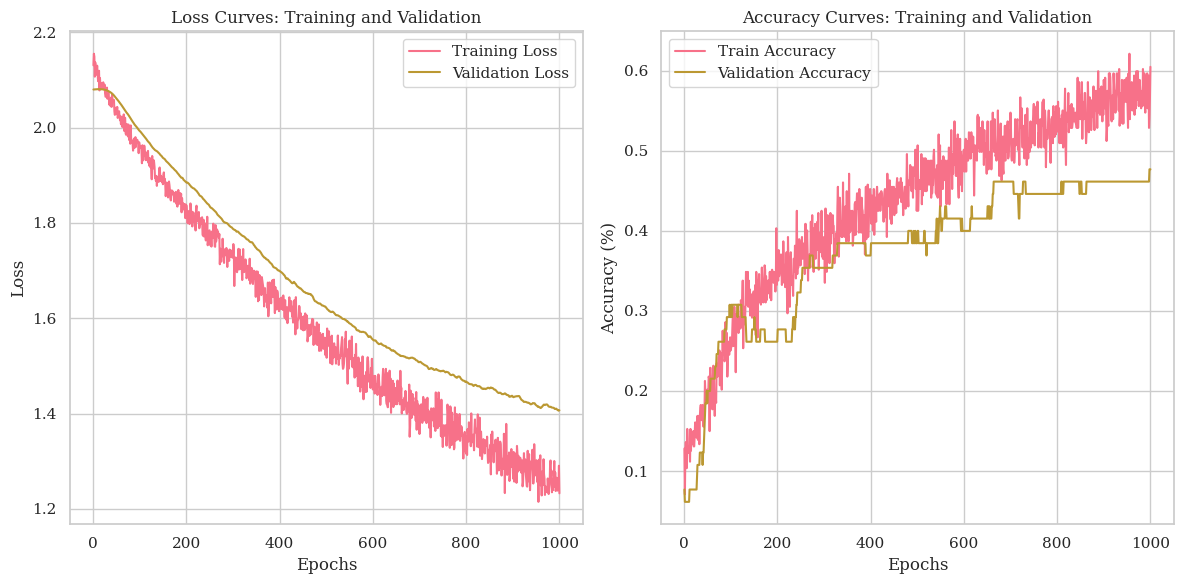

Test set Accuracy: 0.8125
Recall: 0.8125
F1 Score: 0.7660


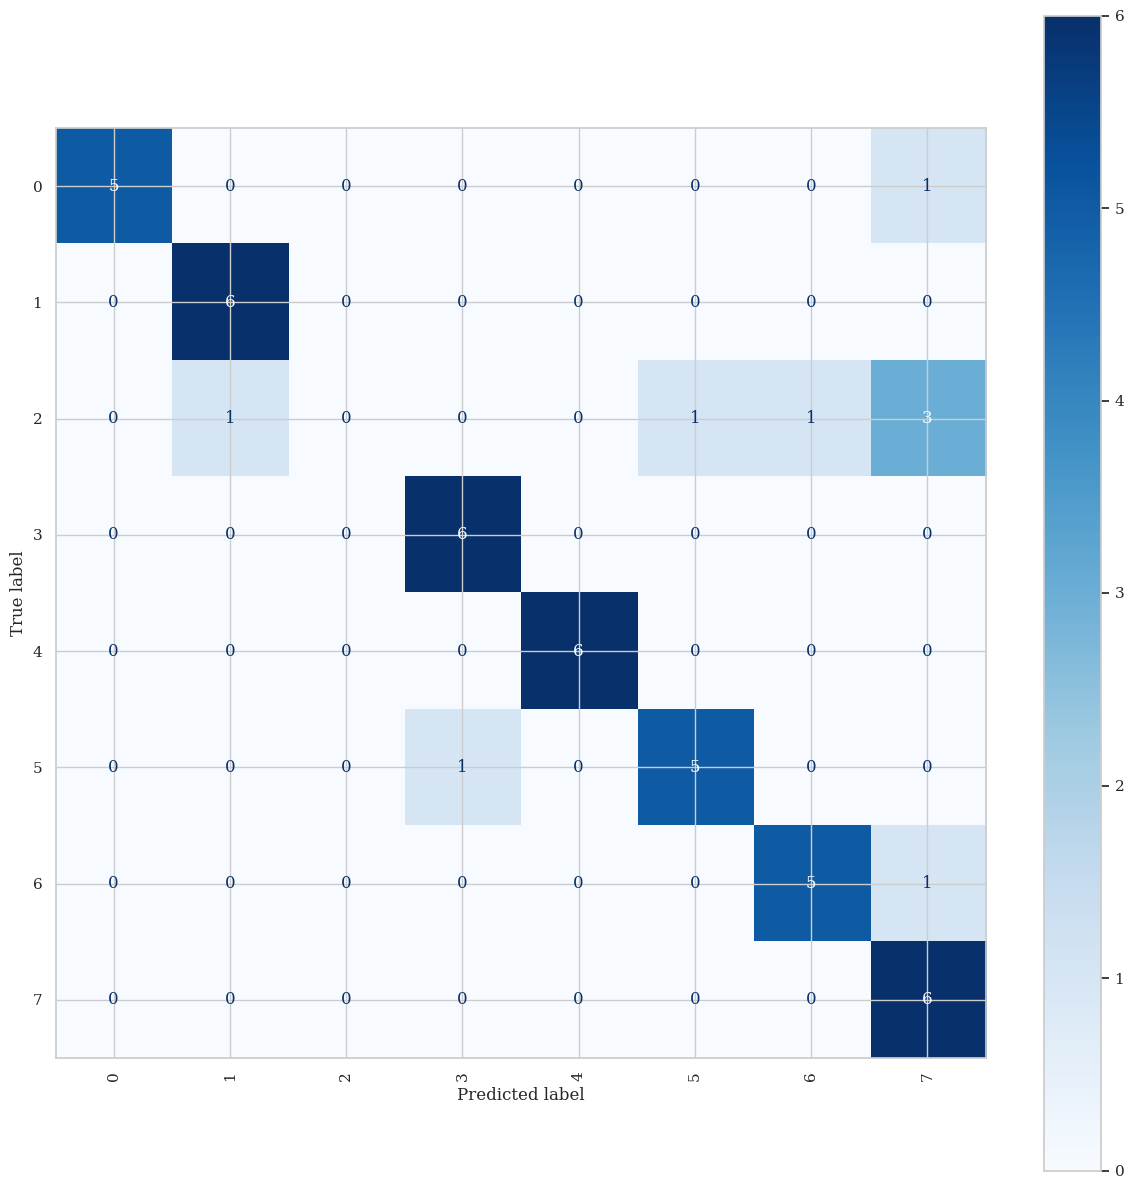

Test User 3 Finished: Accuracy=0.8125, Recall=0.8125, F1=0.7660
--------------------------------------------------
Processando Usuário 4
Train Users: [1, 2, 3, 5, 6, 7, 8, 9, 10]
0
Generating reference for frequency index 0, frequency 8.0 Hz
theta: 0
y shape: (100, 10)
Y shape: (5400, 10)
Y_train shape after freq 8.0 Hz: (5400, 10, 8)
theta: 0
y shape: (100, 10)
Y shape: (600, 10)
Y_test shape after freq 8.0 Hz: (600, 10, 8)
1
Generating reference for frequency index 1, frequency 9.0 Hz
theta: 0
y shape: (100, 10)
Y shape: (5400, 10)
Y_train shape after freq 9.0 Hz: (5400, 10, 8)
theta: 0
y shape: (100, 10)
Y shape: (600, 10)
Y_test shape after freq 9.0 Hz: (600, 10, 8)
2
Generating reference for frequency index 2, frequency 10.0 Hz
theta: 0
y shape: (100, 10)
Y shape: (5400, 10)
Y_train shape after freq 10.0 Hz: (5400, 10, 8)
theta: 0
y shape: (100, 10)
Y shape: (600, 10)
Y_test shape after freq 10.0 Hz: (600, 10, 8)
3
Generating reference for frequency index 3, frequency 11.0 Hz
thet

C:\Users\machi\AppData\Local\Temp\ipykernel_13944\2130039968.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_treino = torch.tensor(rotulos_treinamento, dtype=torch.long).to(device)
C:\Users\machi\AppData\Local\Temp\ipykernel_13944\2130039968.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_teste = torch.tensor(rotulos_teste, dtype=torch.long).to(device)


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000: Train Loss: 2.1312, Train Accuracy: 0.1226, Val Loss: 2.0777, Val Accuracy: 0.1231
Epoch 2/1000: Train Loss: 2.1418, Train Accuracy: 0.1444, Val Loss: 2.0775, Val Accuracy: 0.1231
Epoch 3/1000: Train Loss: 2.1360, Train Accuracy: 0.1199, Val Loss: 2.0773, Val Accuracy: 0.1231
Epoch 4/1000: Train Loss: 2.1393, Train Accuracy: 0.1117, Val Loss: 2.0771, Val Accuracy: 0.1385
Epoch 3/1000: Train Loss: 2.1360, Train Accuracy: 0.1199, Val Loss: 2.0773, Val Accuracy: 0.1231
Epoch 4/1000: Train Loss: 2.1393, Train Accuracy: 0.1117, Val Loss: 2.0771, Val Accuracy: 0.1385
Epoch 5/1000: Train Loss: 2.1363, Train Accuracy: 0.1499, Val Loss: 2.0768, Val Accuracy: 0.1385
Epoch 6/1000: Train Loss: 2.1313, Train Accuracy: 0.1444, Val Loss: 2.0765, Val Accuracy: 0.1385
Epoch 5/1000: Train Loss: 2.1363, Train Accuracy: 0.1499, Val Loss: 2.0768, Val Accuracy: 0.1385
Epoch 6/1000: Train Loss: 2.1313, Train Accuracy: 0.1444, Val Loss: 2.0765, Val Accuracy: 0.1385
Epoch 7/1000: Train Loss: 2.11

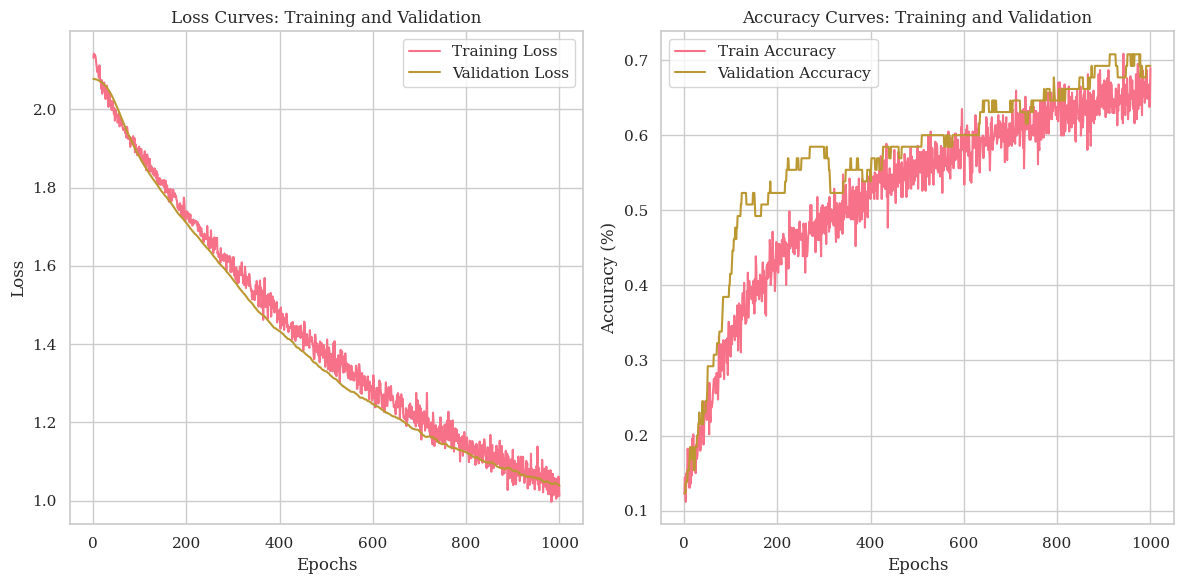

Test set Accuracy: 0.1667
Recall: 0.1667
F1 Score: 0.1635


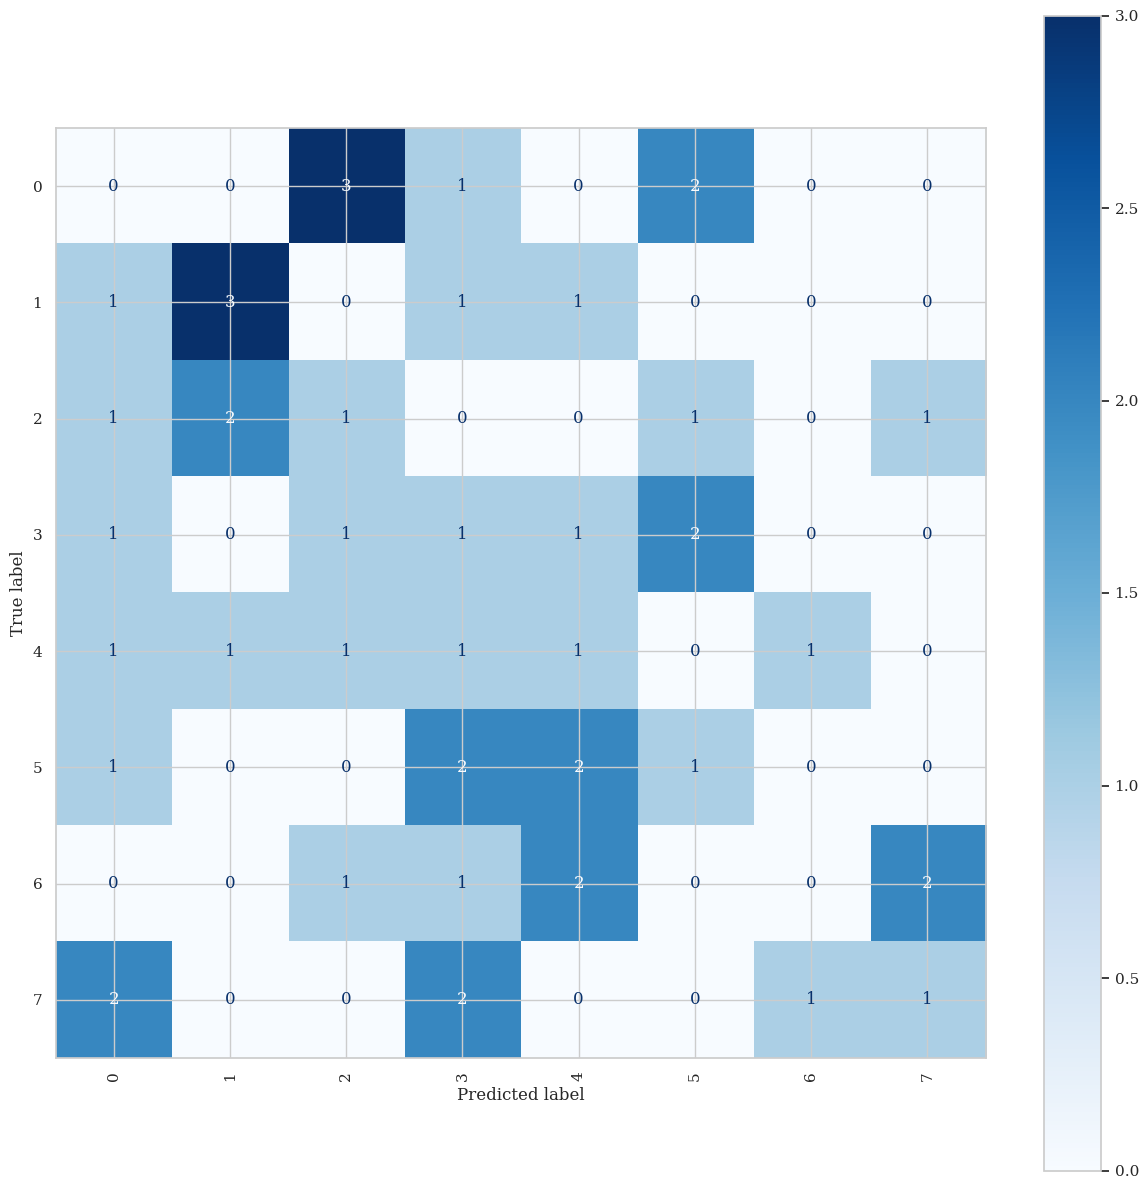

Test User 4 Finished: Accuracy=0.1667, Recall=0.1667, F1=0.1635
--------------------------------------------------
Processando Usuário 5
Train Users: [1, 2, 3, 4, 6, 7, 8, 9, 10]
0
Generating reference for frequency index 0, frequency 8.0 Hz
theta: 0
y shape: (100, 10)
Y shape: (5400, 10)
Y_train shape after freq 8.0 Hz: (5400, 10, 8)
theta: 0
y shape: (100, 10)
Y shape: (600, 10)
Y_test shape after freq 8.0 Hz: (600, 10, 8)
1
Generating reference for frequency index 1, frequency 9.0 Hz
theta: 0
y shape: (100, 10)
Y shape: (5400, 10)
Y_train shape after freq 9.0 Hz: (5400, 10, 8)
theta: 0
y shape: (100, 10)
Y shape: (600, 10)
Y_test shape after freq 9.0 Hz: (600, 10, 8)
2
Generating reference for frequency index 2, frequency 10.0 Hz
theta: 0
y shape: (100, 10)
Y shape: (5400, 10)
Y_train shape after freq 10.0 Hz: (5400, 10, 8)
theta: 0
y shape: (100, 10)
Y shape: (600, 10)
Y_test shape after freq 10.0 Hz: (600, 10, 8)
3
Generating reference for frequency index 3, frequency 11.0 Hz
thet

C:\Users\machi\AppData\Local\Temp\ipykernel_13944\2130039968.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_treino = torch.tensor(rotulos_treinamento, dtype=torch.long).to(device)
C:\Users\machi\AppData\Local\Temp\ipykernel_13944\2130039968.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_teste = torch.tensor(rotulos_teste, dtype=torch.long).to(device)


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000: Train Loss: 2.1177, Train Accuracy: 0.1335, Val Loss: 2.0798, Val Accuracy: 0.1385
Epoch 2/1000: Train Loss: 2.1217, Train Accuracy: 0.1117, Val Loss: 2.0796, Val Accuracy: 0.1231
Epoch 3/1000: Train Loss: 2.1205, Train Accuracy: 0.1553, Val Loss: 2.0794, Val Accuracy: 0.1231
Epoch 4/1000: Train Loss: 2.1485, Train Accuracy: 0.1444, Val Loss: 2.0792, Val Accuracy: 0.1385
Epoch 3/1000: Train Loss: 2.1205, Train Accuracy: 0.1553, Val Loss: 2.0794, Val Accuracy: 0.1231
Epoch 4/1000: Train Loss: 2.1485, Train Accuracy: 0.1444, Val Loss: 2.0792, Val Accuracy: 0.1385
Epoch 5/1000: Train Loss: 2.1183, Train Accuracy: 0.1417, Val Loss: 2.0790, Val Accuracy: 0.1385
Epoch 6/1000: Train Loss: 2.1196, Train Accuracy: 0.1308, Val Loss: 2.0787, Val Accuracy: 0.1385
Epoch 5/1000: Train Loss: 2.1183, Train Accuracy: 0.1417, Val Loss: 2.0790, Val Accuracy: 0.1385
Epoch 6/1000: Train Loss: 2.1196, Train Accuracy: 0.1308, Val Loss: 2.0787, Val Accuracy: 0.1385
Epoch 7/1000: Train Loss: 2.13

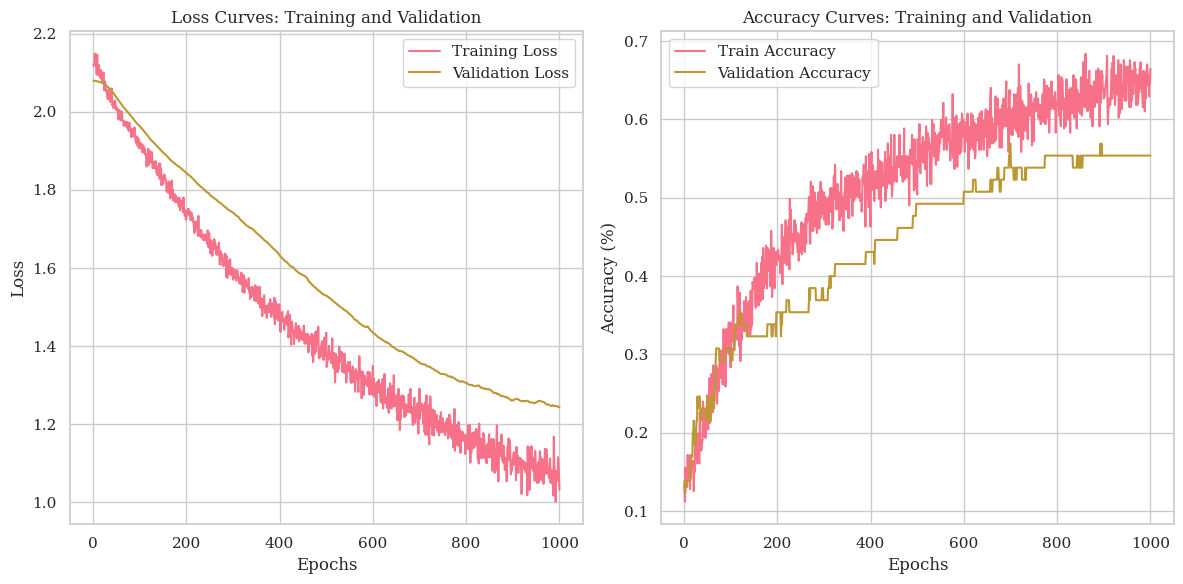

Test set Accuracy: 0.5625
Recall: 0.5625
F1 Score: 0.5585


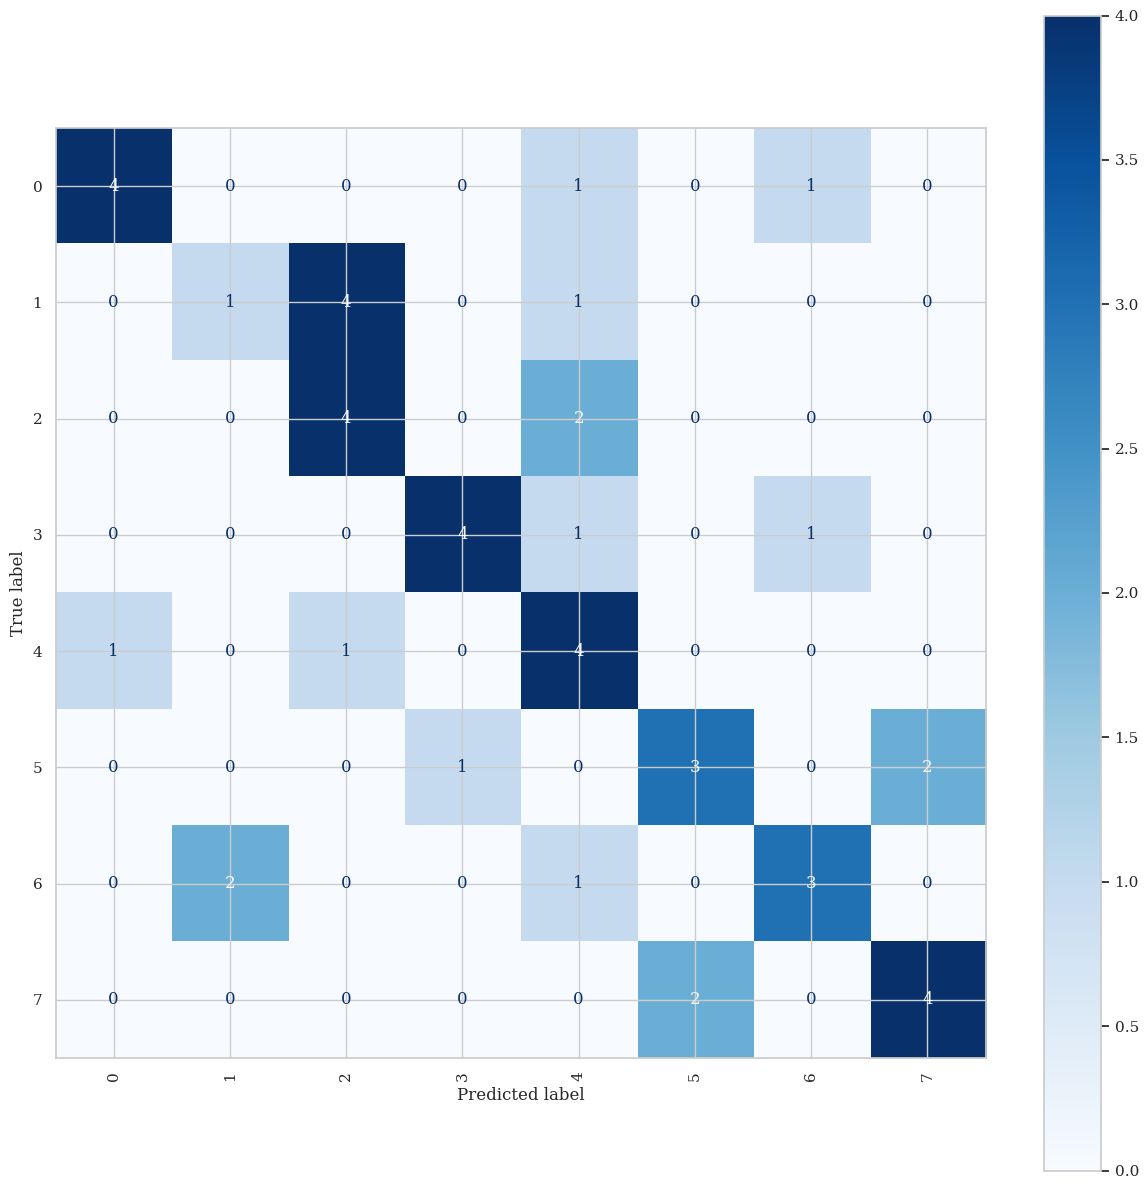

Test User 5 Finished: Accuracy=0.5625, Recall=0.5625, F1=0.5585
--------------------------------------------------
Processando Usuário 6
Train Users: [1, 2, 3, 4, 5, 7, 8, 9, 10]
0
Generating reference for frequency index 0, frequency 8.0 Hz
theta: 0
y shape: (100, 10)
Y shape: (5400, 10)
Y_train shape after freq 8.0 Hz: (5400, 10, 8)
theta: 0
y shape: (100, 10)
Y shape: (600, 10)
Y_test shape after freq 8.0 Hz: (600, 10, 8)
1
Generating reference for frequency index 1, frequency 9.0 Hz
theta: 0
y shape: (100, 10)
Y shape: (5400, 10)
Y_train shape after freq 9.0 Hz: (5400, 10, 8)
theta: 0
y shape: (100, 10)
Y shape: (600, 10)
Y_test shape after freq 9.0 Hz: (600, 10, 8)
2
Generating reference for frequency index 2, frequency 10.0 Hz
theta: 0
y shape: (100, 10)
Y shape: (5400, 10)
Y_train shape after freq 10.0 Hz: (5400, 10, 8)
theta: 0
y shape: (100, 10)
Y shape: (600, 10)
Y_test shape after freq 10.0 Hz: (600, 10, 8)
3
Generating reference for frequency index 3, frequency 11.0 Hz
thet

C:\Users\machi\AppData\Local\Temp\ipykernel_13944\2130039968.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_treino = torch.tensor(rotulos_treinamento, dtype=torch.long).to(device)
C:\Users\machi\AppData\Local\Temp\ipykernel_13944\2130039968.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_teste = torch.tensor(rotulos_teste, dtype=torch.long).to(device)


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000: Train Loss: 2.1311, Train Accuracy: 0.1390, Val Loss: 2.0782, Val Accuracy: 0.1385
Epoch 2/1000: Train Loss: 2.1197, Train Accuracy: 0.1390, Val Loss: 2.0775, Val Accuracy: 0.1231
Epoch 3/1000: Train Loss: 2.1498, Train Accuracy: 0.1035, Val Loss: 2.0769, Val Accuracy: 0.1077
Epoch 4/1000: Train Loss: 2.1196, Train Accuracy: 0.1335, Val Loss: 2.0762, Val Accuracy: 0.1077
Epoch 3/1000: Train Loss: 2.1498, Train Accuracy: 0.1035, Val Loss: 2.0769, Val Accuracy: 0.1077
Epoch 4/1000: Train Loss: 2.1196, Train Accuracy: 0.1335, Val Loss: 2.0762, Val Accuracy: 0.1077
Epoch 5/1000: Train Loss: 2.1269, Train Accuracy: 0.1199, Val Loss: 2.0755, Val Accuracy: 0.0923
Epoch 6/1000: Train Loss: 2.1105, Train Accuracy: 0.1362, Val Loss: 2.0749, Val Accuracy: 0.0769
Epoch 5/1000: Train Loss: 2.1269, Train Accuracy: 0.1199, Val Loss: 2.0755, Val Accuracy: 0.0923
Epoch 6/1000: Train Loss: 2.1105, Train Accuracy: 0.1362, Val Loss: 2.0749, Val Accuracy: 0.0769
Epoch 7/1000: Train Loss: 2.11

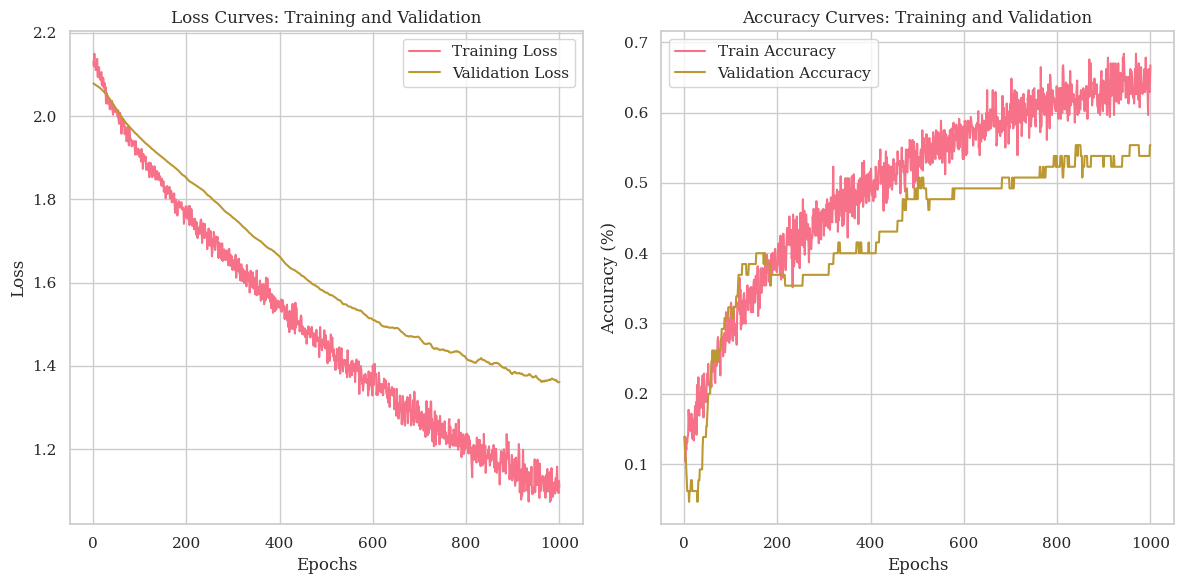

Test set Accuracy: 0.6042
Recall: 0.6042
F1 Score: 0.5676


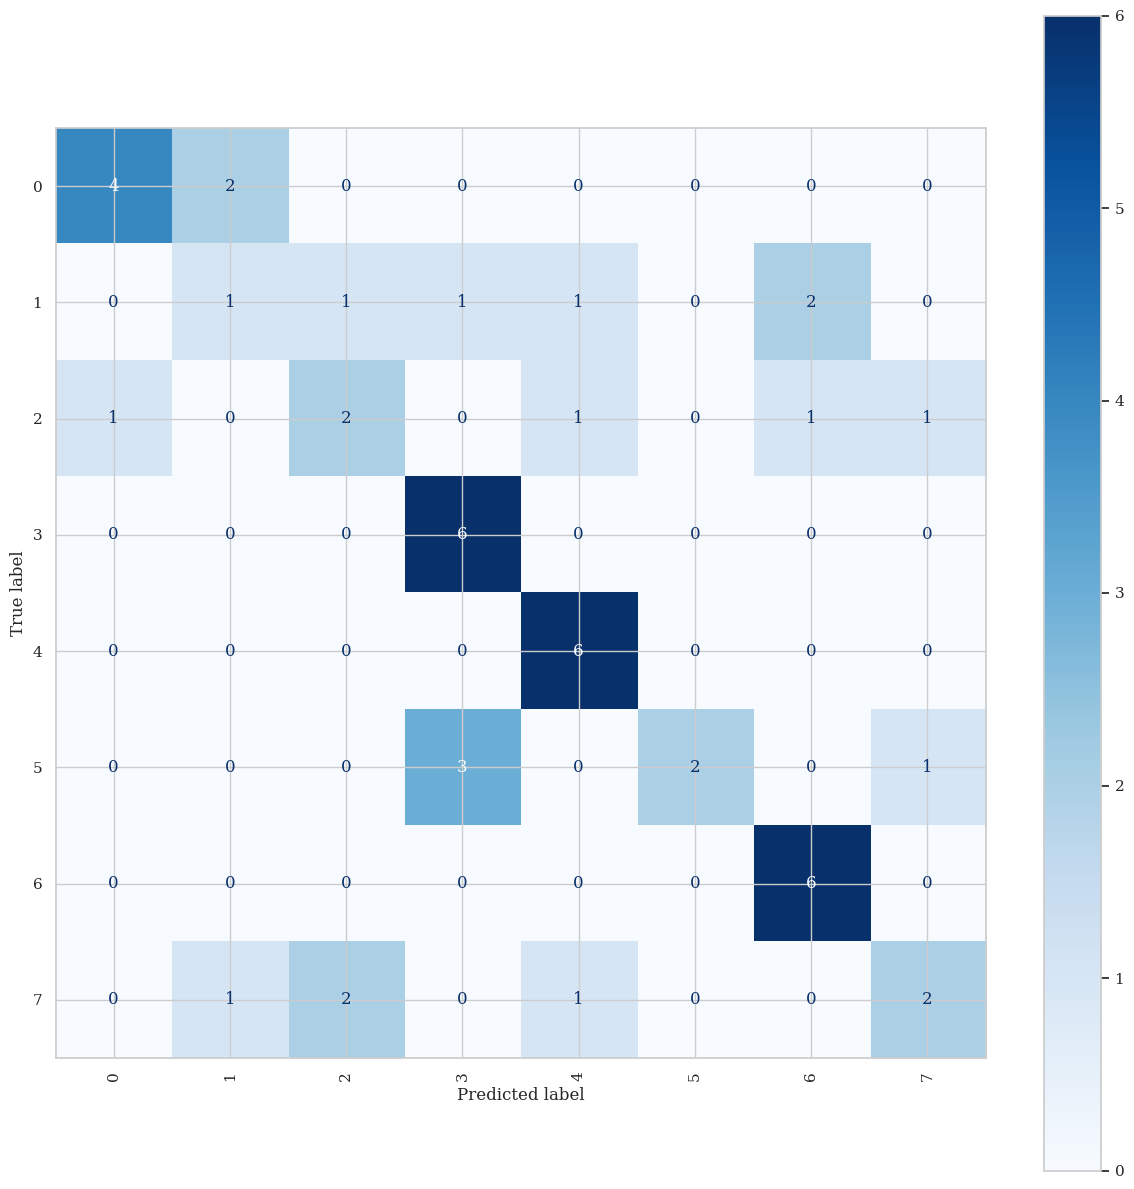

Test User 6 Finished: Accuracy=0.6042, Recall=0.6042, F1=0.5676
--------------------------------------------------
Processando Usuário 7
Train Users: [1, 2, 3, 4, 5, 6, 8, 9, 10]
0
Generating reference for frequency index 0, frequency 8.0 Hz
theta: 0
y shape: (100, 10)
Y shape: (5400, 10)
Y_train shape after freq 8.0 Hz: (5400, 10, 8)
theta: 0
y shape: (100, 10)
Y shape: (600, 10)
Y_test shape after freq 8.0 Hz: (600, 10, 8)
1
Generating reference for frequency index 1, frequency 9.0 Hz
theta: 0
y shape: (100, 10)
Y shape: (5400, 10)
Y_train shape after freq 9.0 Hz: (5400, 10, 8)
theta: 0
y shape: (100, 10)
Y shape: (600, 10)
Y_test shape after freq 9.0 Hz: (600, 10, 8)
2
Generating reference for frequency index 2, frequency 10.0 Hz
theta: 0
y shape: (100, 10)
Y shape: (5400, 10)
Y_train shape after freq 10.0 Hz: (5400, 10, 8)
theta: 0
y shape: (100, 10)
Y shape: (600, 10)
Y_test shape after freq 10.0 Hz: (600, 10, 8)
3
Generating reference for frequency index 3, frequency 11.0 Hz
thet

C:\Users\machi\AppData\Local\Temp\ipykernel_13944\2130039968.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_treino = torch.tensor(rotulos_treinamento, dtype=torch.long).to(device)
C:\Users\machi\AppData\Local\Temp\ipykernel_13944\2130039968.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_teste = torch.tensor(rotulos_teste, dtype=torch.long).to(device)


X_train: torch.Size([432, 8, 100])
X_test: torch.Size([48, 8, 100])
Y_train: torch.Size([432])
Y_test: torch.Size([48])


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000: Train Loss: 2.1775, Train Accuracy: 0.1144, Val Loss: 2.0782, Val Accuracy: 0.1077
Epoch 2/1000: Train Loss: 2.1805, Train Accuracy: 0.1226, Val Loss: 2.0767, Val Accuracy: 0.0769
Epoch 3/1000: Train Loss: 2.1882, Train Accuracy: 0.1226, Val Loss: 2.0753, Val Accuracy: 0.1077
Epoch 4/1000: Train Loss: 2.1681, Train Accuracy: 0.1281, Val Loss: 2.0738, Val Accuracy: 0.1231
Epoch 5/1000: Train Loss: 2.1697, Train Accuracy: 0.1390, Val Loss: 2.0725, Val Accuracy: 0.1231
Epoch 6/1000: Train Loss: 2.1633, Train Accuracy: 0.1281, Val Loss: 2.0710, Val Accuracy: 0.1231
Epoch 7/1000: Train Loss: 2.1521, Train Accuracy: 0.1172, Val Loss: 2.0697, Val Accuracy: 0.1231
Epoch 8/1000: Train Loss: 2.1479, Train Accuracy: 0.1444, Val Loss: 2.0683, Val Accuracy: 0.1231
Epoch 9/1000: Train Loss: 2.1457, Train Accuracy: 0.1281, Val Loss: 2.0670, Val Accuracy: 0.1231
Epoch 10/1000: Train Loss: 2.1404, Train Accuracy: 0.1226, Val Loss: 2.0657, Val Accuracy: 0.1231
Epoch 3/1000: Train Loss: 2.1

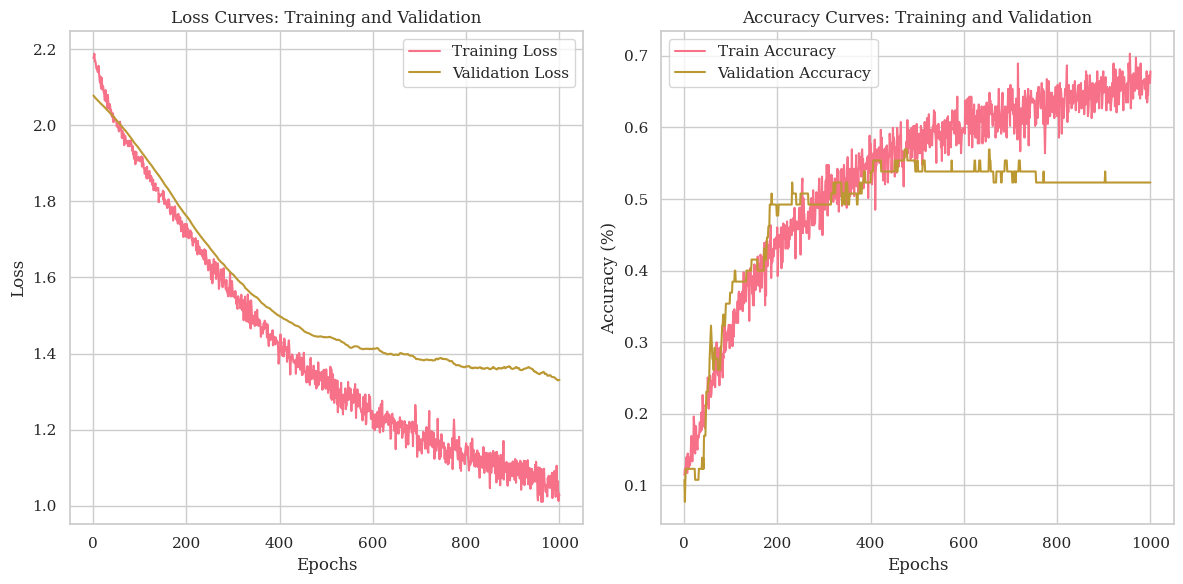

Test set Accuracy: 0.2917
Recall: 0.2917
F1 Score: 0.2813


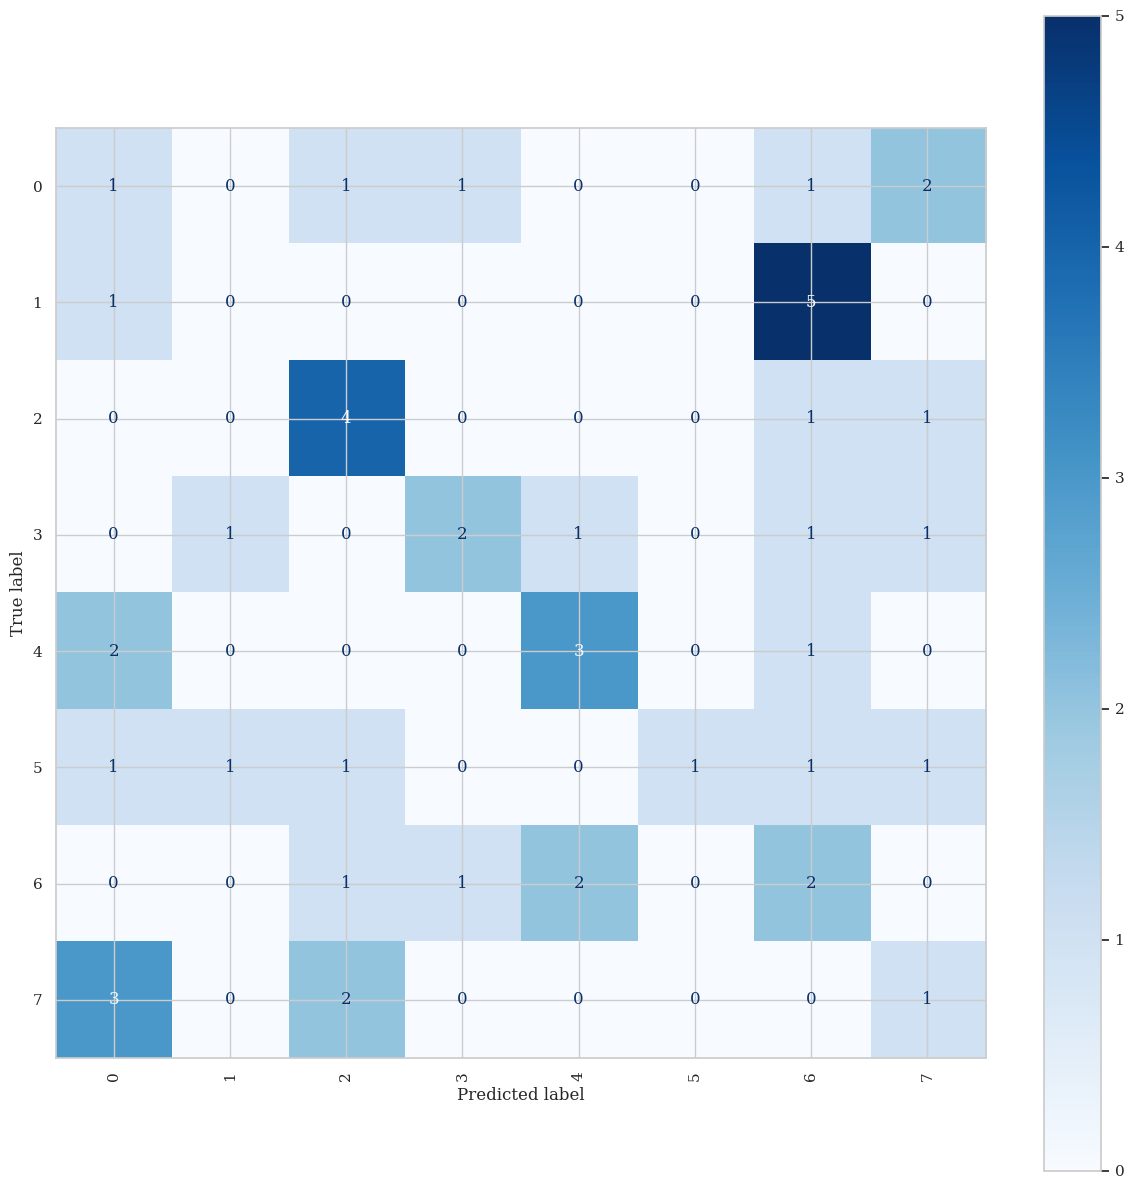

Test User 7 Finished: Accuracy=0.2917, Recall=0.2917, F1=0.2813
--------------------------------------------------
Processando Usuário 8
Train Users: [1, 2, 3, 4, 5, 6, 7, 9, 10]
0
Generating reference for frequency index 0, frequency 8.0 Hz
theta: 0
y shape: (100, 10)
Y shape: (5400, 10)
Y_train shape after freq 8.0 Hz: (5400, 10, 8)
theta: 0
y shape: (100, 10)
Y shape: (600, 10)
Y_test shape after freq 8.0 Hz: (600, 10, 8)
1
Generating reference for frequency index 1, frequency 9.0 Hz
theta: 0
y shape: (100, 10)
Y shape: (5400, 10)
Y_train shape after freq 9.0 Hz: (5400, 10, 8)
theta: 0
y shape: (100, 10)
Y shape: (600, 10)
Y_test shape after freq 9.0 Hz: (600, 10, 8)
2
Generating reference for frequency index 2, frequency 10.0 Hz
theta: 0
y shape: (100, 10)
Y shape: (5400, 10)
Y_train shape after freq 10.0 Hz: (5400, 10, 8)
theta: 0
y shape: (100, 10)
Y shape: (600, 10)
Y_test shape after freq 10.0 Hz: (600, 10, 8)
3
Generating reference for frequency index 3, frequency 11.0 Hz
thet

C:\Users\machi\AppData\Local\Temp\ipykernel_13944\2130039968.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_treino = torch.tensor(rotulos_treinamento, dtype=torch.long).to(device)
C:\Users\machi\AppData\Local\Temp\ipykernel_13944\2130039968.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_teste = torch.tensor(rotulos_teste, dtype=torch.long).to(device)


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000: Train Loss: 2.1069, Train Accuracy: 0.1417, Val Loss: 2.0795, Val Accuracy: 0.0615
Epoch 2/1000: Train Loss: 2.1166, Train Accuracy: 0.1335, Val Loss: 2.0795, Val Accuracy: 0.1077
Epoch 3/1000: Train Loss: 2.1182, Train Accuracy: 0.1035, Val Loss: 2.0797, Val Accuracy: 0.1077
Epoch 4/1000: Train Loss: 2.1026, Train Accuracy: 0.1335, Val Loss: 2.0797, Val Accuracy: 0.1385
Epoch 3/1000: Train Loss: 2.1182, Train Accuracy: 0.1035, Val Loss: 2.0797, Val Accuracy: 0.1077
Epoch 4/1000: Train Loss: 2.1026, Train Accuracy: 0.1335, Val Loss: 2.0797, Val Accuracy: 0.1385
Epoch 5/1000: Train Loss: 2.1111, Train Accuracy: 0.1035, Val Loss: 2.0798, Val Accuracy: 0.1385
Epoch 6/1000: Train Loss: 2.0828, Train Accuracy: 0.1662, Val Loss: 2.0798, Val Accuracy: 0.1385
Epoch 7/1000: Train Loss: 2.0922, Train Accuracy: 0.1281, Val Loss: 2.0798, Val Accuracy: 0.1538
Epoch 8/1000: Train Loss: 2.1035, Train Accuracy: 0.1172, Val Loss: 2.0797, Val Accuracy: 0.1538
Epoch 9/1000: Train Loss: 2.09

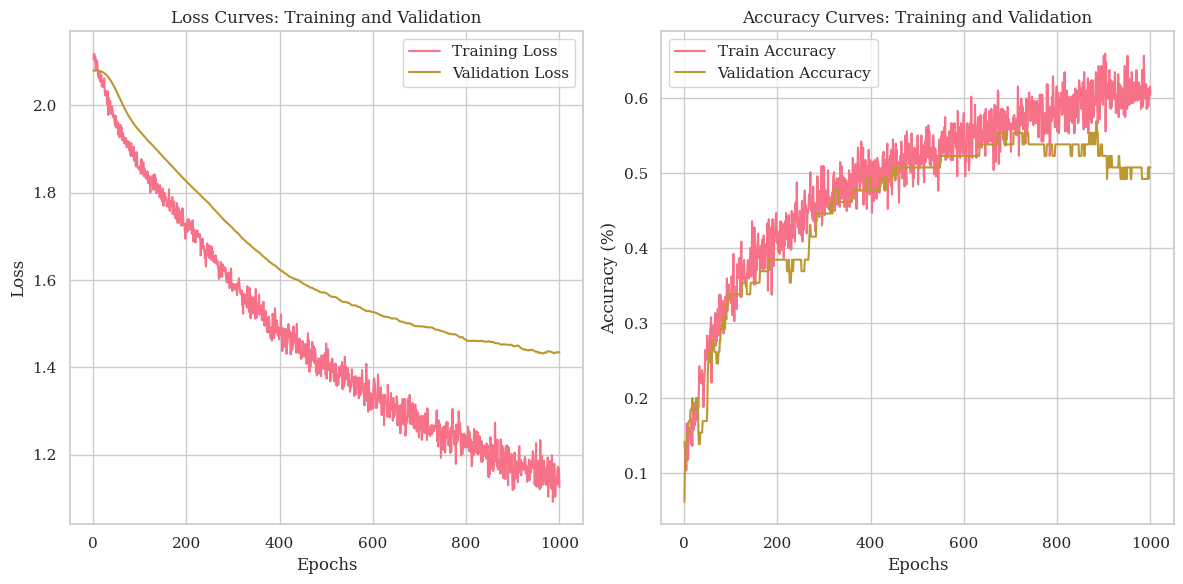

Test set Accuracy: 0.6042
Recall: 0.6042
F1 Score: 0.5630


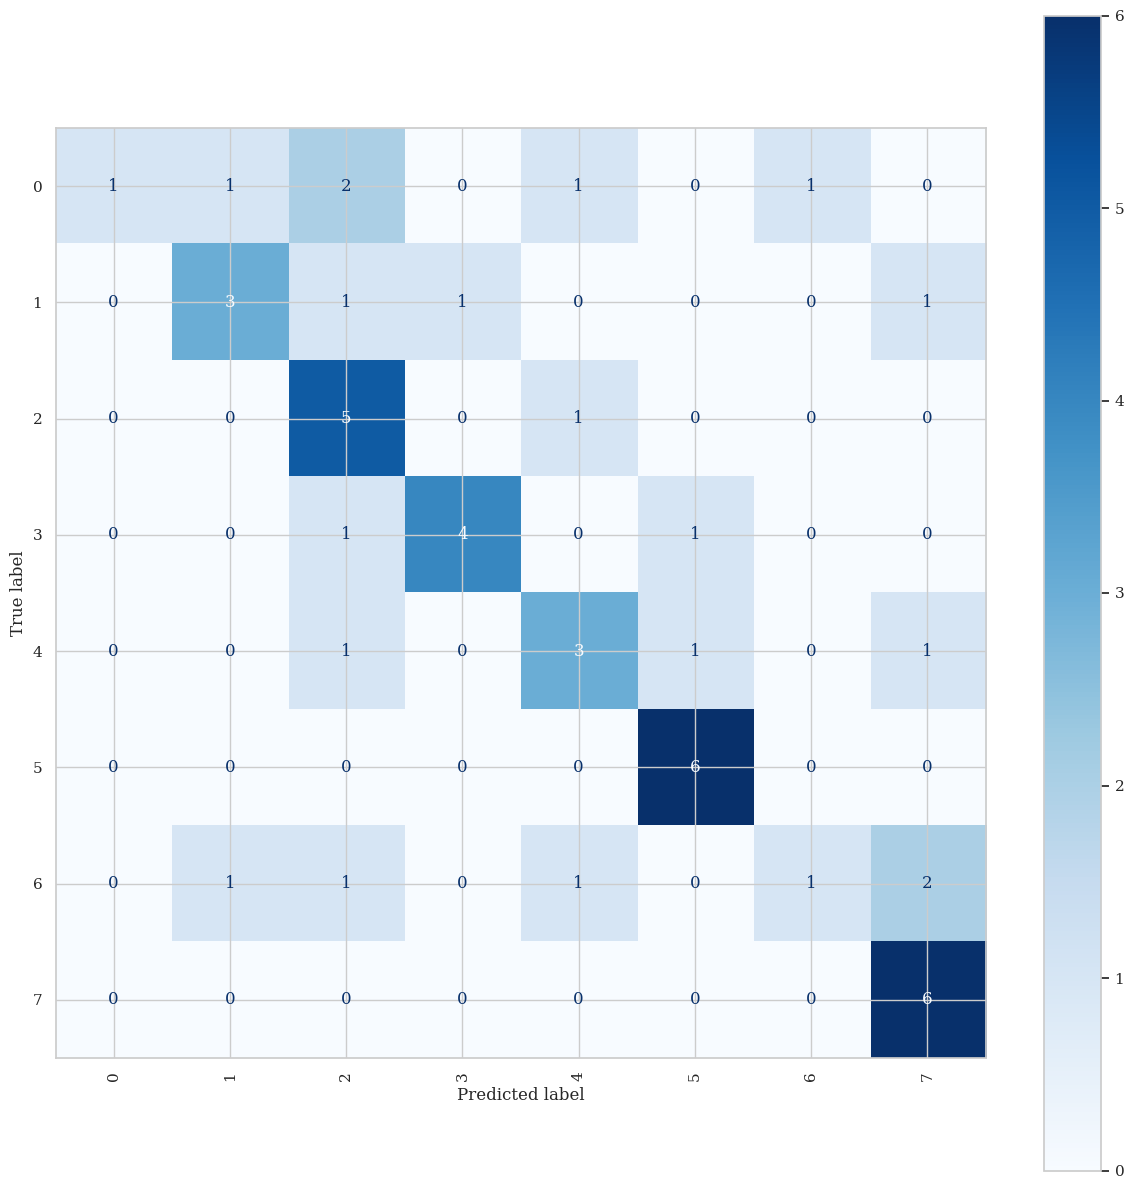

Test User 8 Finished: Accuracy=0.6042, Recall=0.6042, F1=0.5630
--------------------------------------------------
Processando Usuário 9
Train Users: [1, 2, 3, 4, 5, 6, 7, 8, 10]
0
Generating reference for frequency index 0, frequency 8.0 Hz
theta: 0
y shape: (100, 10)
Y shape: (5400, 10)
Y_train shape after freq 8.0 Hz: (5400, 10, 8)
theta: 0
y shape: (100, 10)
Y shape: (600, 10)
Y_test shape after freq 8.0 Hz: (600, 10, 8)
1
Generating reference for frequency index 1, frequency 9.0 Hz
theta: 0
y shape: (100, 10)
Y shape: (5400, 10)
Y_train shape after freq 9.0 Hz: (5400, 10, 8)
theta: 0
y shape: (100, 10)
Y shape: (600, 10)
Y_test shape after freq 9.0 Hz: (600, 10, 8)
2
Generating reference for frequency index 2, frequency 10.0 Hz
theta: 0
y shape: (100, 10)
Y shape: (5400, 10)
Y_train shape after freq 10.0 Hz: (5400, 10, 8)
theta: 0
y shape: (100, 10)
Y shape: (600, 10)
Y_test shape after freq 10.0 Hz: (600, 10, 8)
3
Generating reference for frequency index 3, frequency 11.0 Hz
thet

C:\Users\machi\AppData\Local\Temp\ipykernel_13944\2130039968.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_treino = torch.tensor(rotulos_treinamento, dtype=torch.long).to(device)
C:\Users\machi\AppData\Local\Temp\ipykernel_13944\2130039968.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_teste = torch.tensor(rotulos_teste, dtype=torch.long).to(device)


X_train: torch.Size([432, 8, 100])
X_test: torch.Size([48, 8, 100])
Y_train: torch.Size([432])
Y_test: torch.Size([48])


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000: Train Loss: 2.1131, Train Accuracy: 0.1444, Val Loss: 2.0767, Val Accuracy: 0.2000
Epoch 2/1000: Train Loss: 2.1103, Train Accuracy: 0.1471, Val Loss: 2.0759, Val Accuracy: 0.2000
Epoch 3/1000: Train Loss: 2.1342, Train Accuracy: 0.1362, Val Loss: 2.0750, Val Accuracy: 0.2154
Epoch 4/1000: Train Loss: 2.1156, Train Accuracy: 0.1253, Val Loss: 2.0741, Val Accuracy: 0.1846
Epoch 3/1000: Train Loss: 2.1342, Train Accuracy: 0.1362, Val Loss: 2.0750, Val Accuracy: 0.2154
Epoch 4/1000: Train Loss: 2.1156, Train Accuracy: 0.1253, Val Loss: 2.0741, Val Accuracy: 0.1846
Epoch 5/1000: Train Loss: 2.1029, Train Accuracy: 0.1771, Val Loss: 2.0732, Val Accuracy: 0.2154
Epoch 6/1000: Train Loss: 2.0984, Train Accuracy: 0.1335, Val Loss: 2.0723, Val Accuracy: 0.2154
Epoch 7/1000: Train Loss: 2.1091, Train Accuracy: 0.1471, Val Loss: 2.0713, Val Accuracy: 0.2154
Epoch 8/1000: Train Loss: 2.0827, Train Accuracy: 0.1608, Val Loss: 2.0704, Val Accuracy: 0.2154
Epoch 9/1000: Train Loss: 2.11

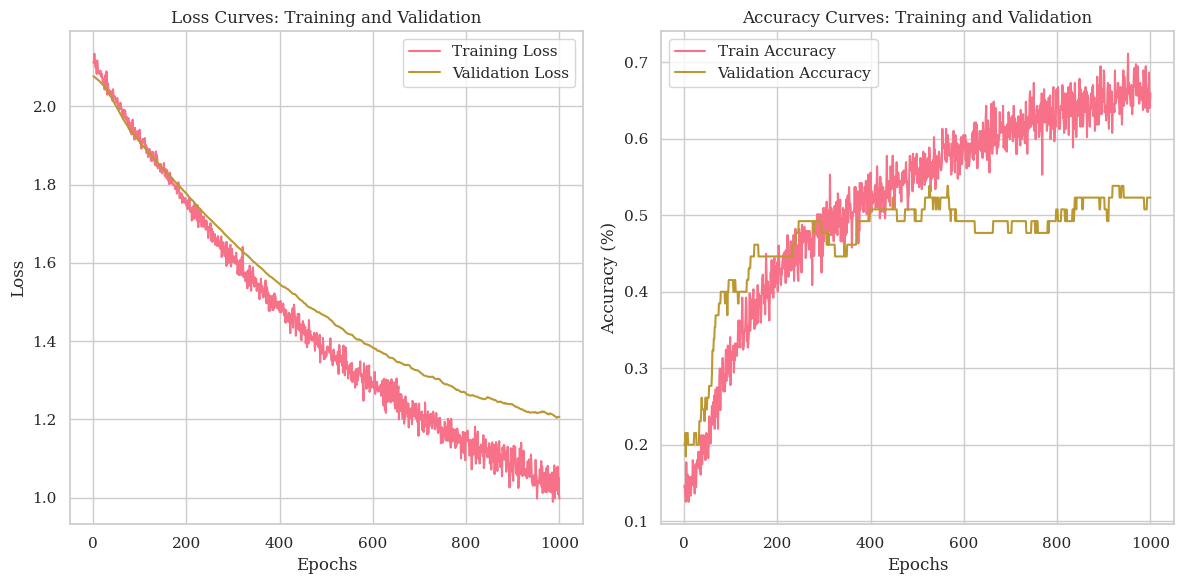

Test set Accuracy: 0.1875
Recall: 0.1875
F1 Score: 0.1775


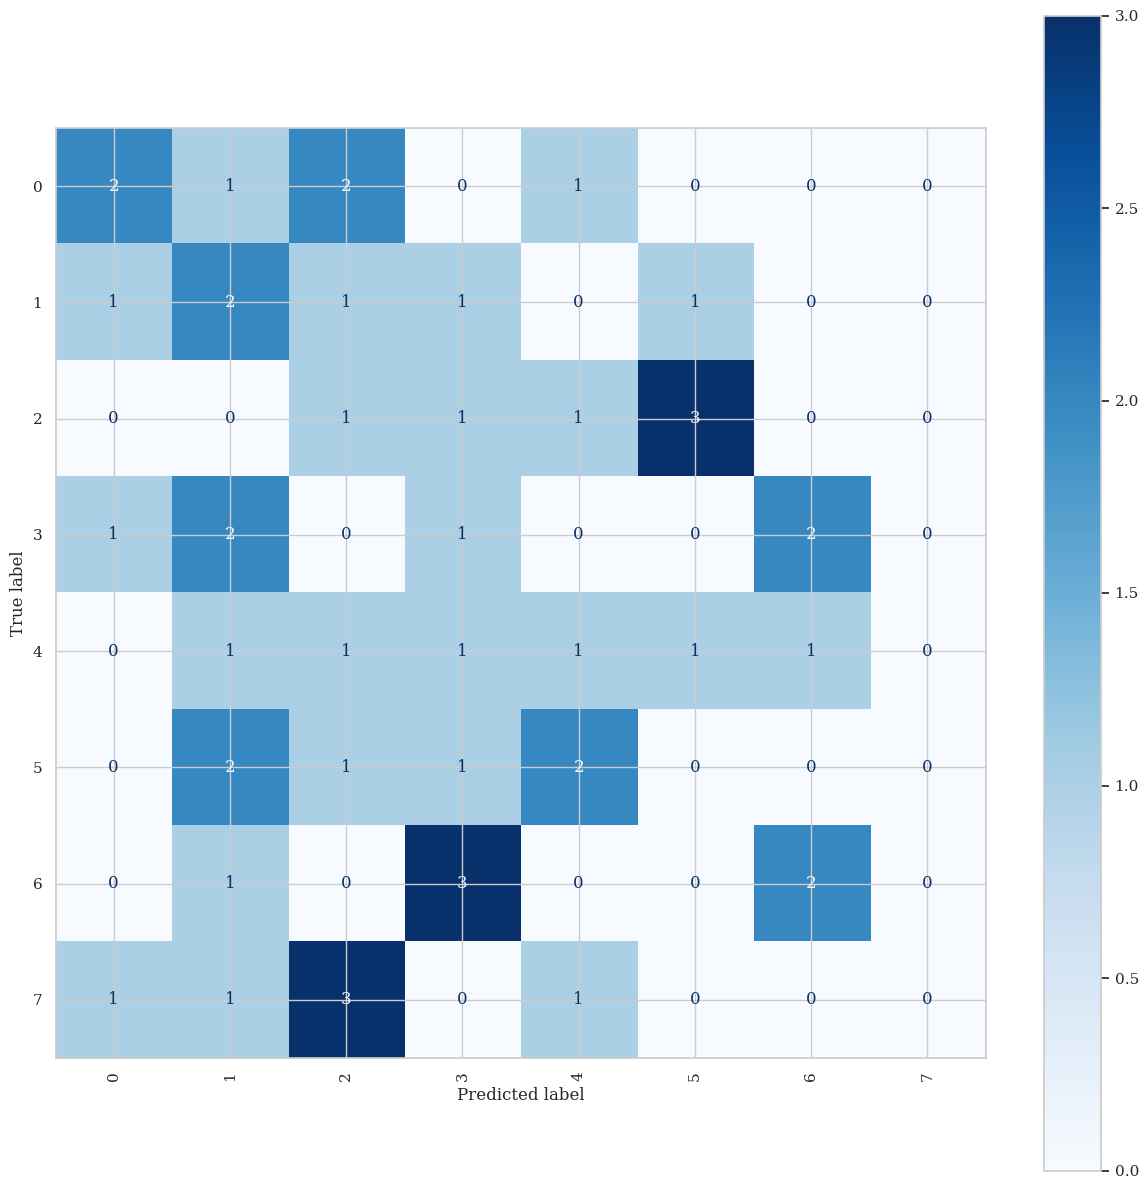

Test User 9 Finished: Accuracy=0.1875, Recall=0.1875, F1=0.1775
--------------------------------------------------
Processando Usuário 10
Train Users: [1, 2, 3, 4, 5, 6, 7, 8, 9]
0
Generating reference for frequency index 0, frequency 8.0 Hz
theta: 0
y shape: (100, 10)
Y shape: (5400, 10)
Y_train shape after freq 8.0 Hz: (5400, 10, 8)
theta: 0
y shape: (100, 10)
Y shape: (600, 10)
Y_test shape after freq 8.0 Hz: (600, 10, 8)
1
Generating reference for frequency index 1, frequency 9.0 Hz
theta: 0
y shape: (100, 10)
Y shape: (5400, 10)
Y_train shape after freq 9.0 Hz: (5400, 10, 8)
theta: 0
y shape: (100, 10)
Y shape: (600, 10)
Y_test shape after freq 9.0 Hz: (600, 10, 8)
2
Generating reference for frequency index 2, frequency 10.0 Hz
theta: 0
y shape: (100, 10)
Y shape: (5400, 10)
Y_train shape after freq 10.0 Hz: (5400, 10, 8)
theta: 0
y shape: (100, 10)
Y shape: (600, 10)
Y_test shape after freq 10.0 Hz: (600, 10, 8)
3
Generating reference for frequency index 3, frequency 11.0 Hz
thet

C:\Users\machi\AppData\Local\Temp\ipykernel_13944\2130039968.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_treino = torch.tensor(rotulos_treinamento, dtype=torch.long).to(device)
C:\Users\machi\AppData\Local\Temp\ipykernel_13944\2130039968.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_teste = torch.tensor(rotulos_teste, dtype=torch.long).to(device)


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000: Train Loss: 2.1161, Train Accuracy: 0.1417, Val Loss: 2.0823, Val Accuracy: 0.0769
Epoch 2/1000: Train Loss: 2.1194, Train Accuracy: 0.1390, Val Loss: 2.0821, Val Accuracy: 0.0769
Epoch 3/1000: Train Loss: 2.1309, Train Accuracy: 0.1117, Val Loss: 2.0819, Val Accuracy: 0.1077
Epoch 2/1000: Train Loss: 2.1194, Train Accuracy: 0.1390, Val Loss: 2.0821, Val Accuracy: 0.0769
Epoch 3/1000: Train Loss: 2.1309, Train Accuracy: 0.1117, Val Loss: 2.0819, Val Accuracy: 0.1077
Epoch 4/1000: Train Loss: 2.0917, Train Accuracy: 0.1499, Val Loss: 2.0818, Val Accuracy: 0.1231
Epoch 5/1000: Train Loss: 2.1072, Train Accuracy: 0.1608, Val Loss: 2.0816, Val Accuracy: 0.1231
Epoch 4/1000: Train Loss: 2.0917, Train Accuracy: 0.1499, Val Loss: 2.0818, Val Accuracy: 0.1231
Epoch 5/1000: Train Loss: 2.1072, Train Accuracy: 0.1608, Val Loss: 2.0816, Val Accuracy: 0.1231
Epoch 6/1000: Train Loss: 2.1229, Train Accuracy: 0.1390, Val Loss: 2.0814, Val Accuracy: 0.1385
Epoch 7/1000: Train Loss: 2.09

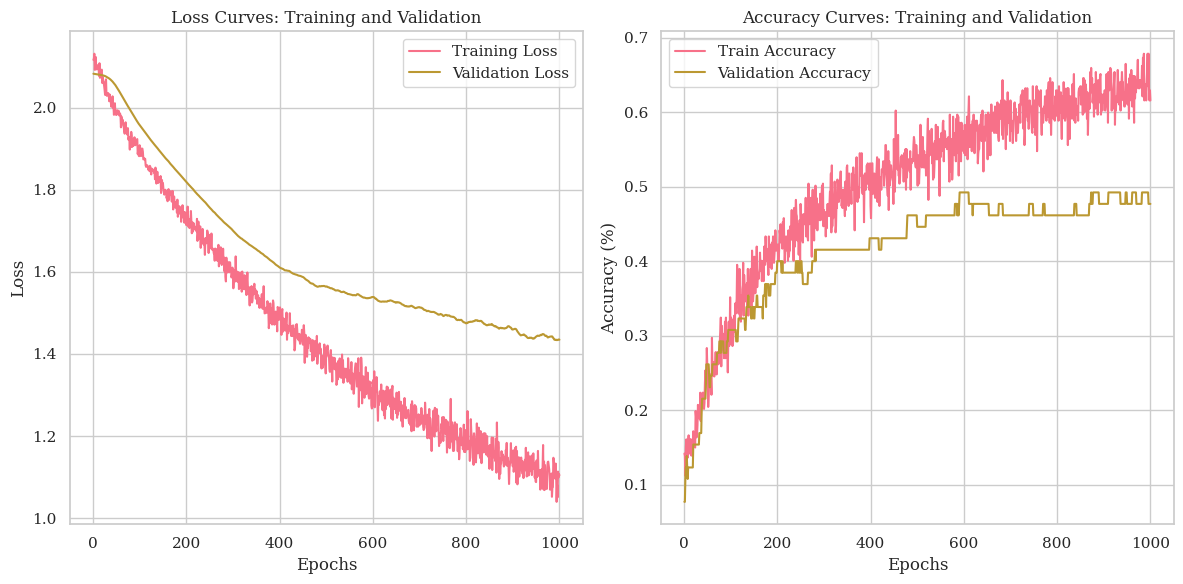

Test set Accuracy: 0.6458
Recall: 0.6458
F1 Score: 0.6279


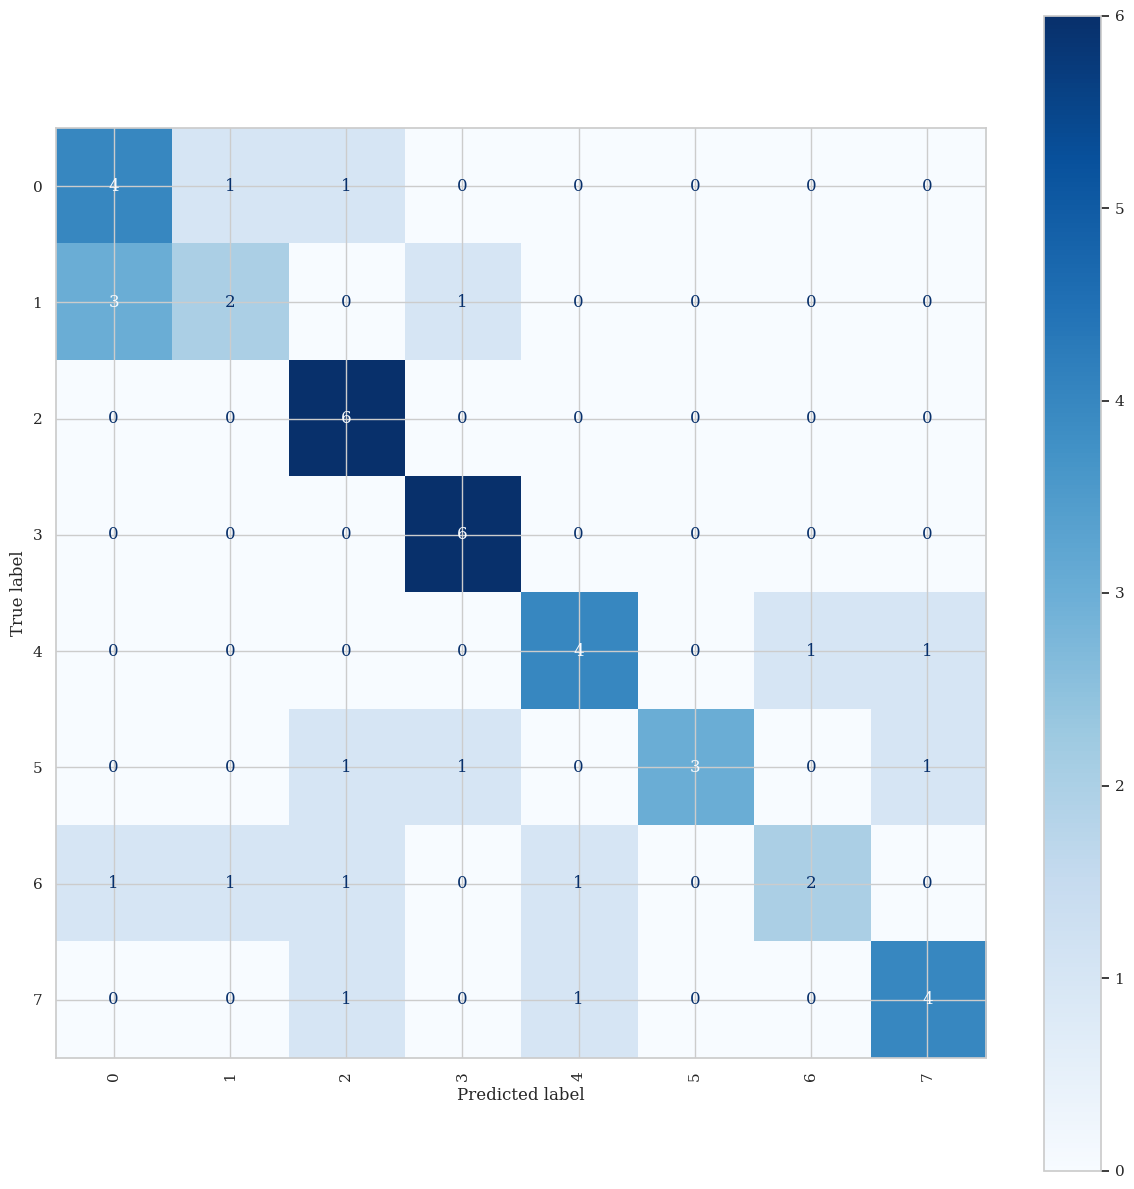

Test User 10 Finished: Accuracy=0.6458, Recall=0.6458, F1=0.6279
--------------------------------------------------


In [9]:
seed = 42
torch.cuda.manual_seed(seed)
torch.manual_seed(seed)

# Cross-Subject EEGNet Training (single window per trial, no window separation)
metricas_usuarios = []
exp_dir.mkdir(parents=True, exist_ok=True)

# Prepare cross-subject splits
for test_user_idx, test_user in enumerate(users):
    print(f"Processando Usuário {test_user}")
    train_users = [u for u in users if u != test_user]
    print(f"Train Users: {train_users}")

    # Concatenate training data from all train_users
    train_data = np.concatenate(
        [all_data[users.index(u)] for u in train_users], axis=-1
    )  # shape: (channels, samples, freqs, trials)
    test_data = all_data[test_user_idx]

    num_canais, _, num_freqs, num_trials_train = train_data.shape
    num_trials_test = test_data.shape[-1]

    # Prepare reference matrices for all frequencies (no window separation)
    Y_train = np.zeros(
        (tamanho_da_janela * num_trials_train, num_harmonica * 2, len(indices))
    )
    Y_test = np.zeros(
        (tamanho_da_janela * num_trials_test, num_harmonica * 2, len(indices))
    )
    for k in indices:
        print(k)
        print(
            f"Generating reference for frequency index {k}, frequency {frequencias[k]} Hz"
        )
        y_train = matriz_referencia(
            num_harmonica,
            inform_fase,
            num_trials_train,
            frequencias[k],
            fases,
            tamanho_da_janela,
        )
        Y_train[:, :, k] = y_train
        print(f"Y_train shape after freq {frequencias[k]} Hz: {Y_train.shape}")
        y_test = matriz_referencia(
            num_harmonica,
            inform_fase,
            num_trials_test,
            frequencias[k],
            fases,
            tamanho_da_janela,
        )
        Y_test[:, :, k] = y_test
        print(f"Y_test shape after freq {frequencias[k]} Hz: {Y_test.shape}")

    X_train = np.zeros(
        (tamanho_da_janela * num_trials_train, len(occipital_electrodes), len(indices))
    )
    X_test = np.zeros(
        (tamanho_da_janela * num_trials_test, len(occipital_electrodes), len(indices))
    )

    for k in range(len(indices)):
        # For training: each trial is a single window
        eeg_matrix_train = train_data[
            occipital_electrodes, :tamanho_da_janela, indices[k], :
        ]
        eeg_matrix_test = test_data[
            occipital_electrodes, :tamanho_da_janela, indices[k], :
        ]
        # Transpõe os dados para que cada linha represente uma amostra
        eeg_matrix_train = np.transpose(eeg_matrix_train)
        eeg_matrix_test = np.transpose(eeg_matrix_test)
        eeg_matrix_train = np.concatenate(eeg_matrix_train, axis=0)
        eeg_matrix_test = np.concatenate(eeg_matrix_test, axis=0)

        X_train[:, :, k] = eeg_matrix_train
        X_test[:, :, k] = eeg_matrix_test

    # CCA optimization (across all training data)
    Combinadores_Y = []
    Combinadores_X = []
    correlacoes_max = []
    for k in range(len(indices)):
        Wx, Wy, corr = CCA_otimizacao(X_train[:, :, k], Y_train[:, :, k])
        Combinadores_Y.append(Wy)
        Combinadores_X.append(Wx)
        correlacoes_max.append(corr)
    Combinadores_X = np.column_stack(Combinadores_X)
    Combinadores_Y = np.column_stack(Combinadores_Y)

    # Separar em janelas
    X_teste_janelas = []
    X_treino_janelas = []
    Y_teste_janelas = []
    Y_treino_janelas = []

    for k in range(len(indices)):
        X_t, numero_janelas_teste = get_windows(
            X_test[:, :, k], tamanho_da_janela, include_last=False
        )
        Y_t, _ = get_windows(Y_test[:, :, k], tamanho_da_janela, include_last=False)

        X_v, numero_janelas_treino = get_windows(
            X_train[:, :, k], tamanho_da_janela, include_last=False
        )
        Y_v, _ = get_windows(Y_train[:, :, k], tamanho_da_janela, include_last=False)

        X_teste_janelas.append(X_t)
        Y_teste_janelas.append(Y_t)

        X_treino_janelas.append(X_v)
        Y_treino_janelas.append(Y_v)

    # Construir tensor de treinamento
    rotulos_treinamento = []
    tensor_treinamento = np.zeros(
        [len(indices) * num_trials_train, len(indices), tamanho_da_janela]
    )
    cont = 0

    for m in range(len(indices)):
        for j in range(numero_janelas_treino):
            janela_x = X_treino_janelas[m][j]
            rotulos_treinamento.append(frequencias[indices[m]])
            cont_1 = 0
            for w in range(len(indices)):
                Wx = Combinadores_X[:, w]

                projecao_x = np.dot(Wx, janela_x.T)
                tensor_treinamento[cont, cont_1, :] = projecao_x

                cont_1 += 1
            cont += 1

    rotulos_teste = []
    tensor_teste = np.zeros(
        [len(indices) * num_trials_test, len(indices), tamanho_da_janela]
    )
    cont = 0

    for m in range(len(indices)):
        for j in range(numero_janelas_teste):
            janela_x = X_teste_janelas[m][j]
            rotulos_teste.append(frequencias[indices[m]])
            cont_1 = 0

            for w in range(len(indices)):
                Wx = Combinadores_X[:, w]

                projecao_x = np.dot(Wx, janela_x.T)
                tensor_teste[cont, cont_1, :] = projecao_x

                cont_1 += 1
            cont += 1

    # Map labels to indices
    mapeamento = {rotulo: i for i, rotulo in enumerate(sorted(frequencias_desejadas))}
    rotulos_treinamento = torch.tensor(
        [
            mapeamento[rotulo.item()] if hasattr(rotulo, "item") else mapeamento[rotulo]
            for rotulo in rotulos_treinamento
        ]
    )
    rotulos_teste = torch.tensor(
        [
            mapeamento[rotulo.item()] if hasattr(rotulo, "item") else mapeamento[rotulo]
            for rotulo in rotulos_teste
        ]
    )

    X_treino = torch.tensor(tensor_treinamento, dtype=torch.float32).to(device)
    X_teste = torch.tensor(tensor_teste, dtype=torch.float32).to(device)
    Y_treino = torch.tensor(rotulos_treinamento, dtype=torch.long).to(device)
    Y_teste = torch.tensor(rotulos_teste, dtype=torch.long).to(device)
    print("X_train:", X_treino.shape)
    print("X_test:", X_teste.shape)
    print("Y_train:", Y_treino.shape)
    print("Y_test:", Y_teste.shape)

    # Model setup
    model = EEGNetv4(
        n_chans=8,
        n_outputs=8,
        n_times=tamanho_da_janela,
        kernel_length=(tamanho_da_janela // 2),
    )

    model = model.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    dataset = TensorDataset(X_treino, Y_treino)
    train_size = int(0.85 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(
        dataset, [train_size, val_size], generator=torch.Generator().manual_seed(seed)
    )
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    test_loader = DataLoader(
        TensorDataset(X_teste, Y_teste), batch_size=10, shuffle=False
    )

    # Train
    best_model = train(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        num_epochs=epochs,
        device=device,
        save_path=exp_dir.joinpath(f"best_model_user_{test_user}.pth"),
    )

    # Evaluate
    accuracy, recall, f1, cm = evaluate(best_model, test_loader)

    metricas_usuarios.append(
        {
            "usuario": test_user,
            "acuracia": accuracy,
            "recall": recall,
            "f1-score": f1,
            "confusion_matrix": cm,
        }
    )
    print(
        f"Test User {test_user} Finished: Accuracy={accuracy:.4f}, Recall={recall:.4f}, F1={f1:.4f}"
    )

    # Salvar as métricas de cada usuário
    df_metricas = pd.DataFrame(metricas_usuarios)
    df_metricas.to_csv(exp_dir.joinpath("metricas.csv"), index=False)

    print("-" * 50)